# Instacart - online grocery shop exploratory data analysis


Info via Wikipedia: *Instacart, headquartered in San Francisco, operates a grocery delivery and pick-up service in the United States and Canada.* 

This analysis will present the methods of exploratory data analysis and customer segmentation for the internal needs of the online store.

data source: https://www.instacart.com/datasets/grocery-shopping-2017 (1.05.2020)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from apyori import apriori

plt.style.use('seaborn')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

First, all tables will be imported and shortly described.

In [2]:
df = pd.read_csv('order_products__prior.csv', low_memory=False)
df = df.set_index('order_id')
print('Number of rows: {:,}'.format(df.shape[0]))
df.head()

Number of rows: 32,434,489


product_id  add_to_cart_order  reordered
order_id                                          
2              33120                  1          1
2              28985                  2          1
2               9327                  3          0
2              45918                  4          1
2              30035                  5          0

*order_products__prior.csv* contains the largest amount of data, it can be considered the main data table, so it has been assigned the standard name '*df*'. The table contains almost 32,434,489 rows, where each single one of them contains information about single purchased product. This means that, according to the data, 32.5 million products were purchased in a given period. In addition, information about the order in which the product was added to the basket and whether the product was already ordered by the customer is provided aswell.

In [3]:
products = pd.read_csv('products.csv', index_col='product_id')
print('Number of rows: {:,}'.format(products.shape[0]))
products.head()

Number of rows: 49,688


product_name  aisle_id  \
product_id                                                                
1                                  Chocolate Sandwich Cookies        61   
2                                            All-Seasons Salt       104   
3                        Robust Golden Unsweetened Oolong Tea        94   
4           Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
5                                   Green Chile Anytime Sauce         5   

            department_id  
product_id                 
1                      19  
2                      13  
3                       7  
4                       1  
5                      13

The next table is a table containing information about all available products. Based on this, it can be noticed that the store has about 49.5k unique products available for sell. Each of them has aisle and department assigned. Below, tables regarding these features are presented.

In [4]:
departments = pd.read_csv('departments.csv', index_col='department_id')
print('Number of rows: {:,}'.format(departments.shape[0]))
departments.head()

Number of rows: 21


department
department_id           
1                 frozen
2                  other
3                 bakery
4                produce
5                alcohol

In [5]:
aisles = pd.read_csv('aisles.csv', index_col='aisle_id')
print('Number of rows: {:,}'.format(aisles.shape[0]))
aisles.head()

Number of rows: 134


aisle
aisle_id                            
1              prepared soups salads
2                  specialty cheeses
3                energy granola bars
4                      instant foods
5         marinades meat preparation

The next two tables present a list of all departments and aisles to which individual products are assigned. There are 21 departments that contain very general information about the category to which the product is assigned, such as bread or alcohol. Each department is divided into smaller categories, i.e. aisle, which provide more detailed information on product categories. There are more aisles than departments - as many as 134.

In [6]:
orders = pd.read_csv('orders.csv')
orders = orders.set_index('order_id')
print('Number of rows: {:,}'.format(orders.shape[0]))
orders.head()

Number of rows: 3,421,083


user_id eval_set  order_number  order_dow  order_hour_of_day  \
order_id                                                                 
2539329         1    prior             1          2                  8   
2398795         1    prior             2          3                  7   
473747          1    prior             3          3                 12   
2254736         1    prior             4          4                  7   
431534          1    prior             5          4                 15   

          days_since_prior_order  
order_id                          
2539329                      nan  
2398795                 15.00000  
473747                  21.00000  
2254736                 29.00000  
431534                  28.00000

The last, fifth table orders.csv does not contain direct information about products that are included in individual orders, but information at the level of individual orders. The information indicates the customer who placed the order, the hour and the day of the week of placing the order and the number of days since the previous order by the given customer.

All of the above tables were built on the principle of a relational database, so they can be easily merged and analyzed at the same time. As an example below, three tables containing information about products (pruducts, departments and aisles) will be merged together into single table.

In [7]:
products = pd.merge(products, aisles, left_on='aisle_id', right_index=True)
products = pd.merge(products, departments, left_on='department_id', right_index=True)
products.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
products.sort_index(inplace=True)
products.head()

product_name  \
product_id                                                      
1                                  Chocolate Sandwich Cookies   
2                                            All-Seasons Salt   
3                        Robust Golden Unsweetened Oolong Tea   
4           Smart Ones Classic Favorites Mini Rigatoni Wit...   
5                                   Green Chile Anytime Sauce   

                                 aisle department  
product_id                                         
1                        cookies cakes     snacks  
2                    spices seasonings     pantry  
3                                  tea  beverages  
4                         frozen meals     frozen  
5           marinades meat preparation     pantry

Information that does not require complicated data processing over a simple merge of tables will be analyzed in the first place. Before even that, a simple function will be defined that will display value above each bar in the barcharts - such graphs will be used repeatedly in this analysis and there is no reason for the same code to be copied and pasted many times.

In [8]:
def display_count(plot, formatting, size, div=1, rnd=2):
    for p in plot.patches:
        plot.annotate(
            s = formatting.format(round(p.get_height()/div, rnd)), 
            xy = (p.get_x() + p.get_width() / 2, p.get_height()),
            ha = 'center', 
            va = 'center', 
            xytext = (0, 8), 
            textcoords = 'offset points',
            color='black',
            fontsize=size)

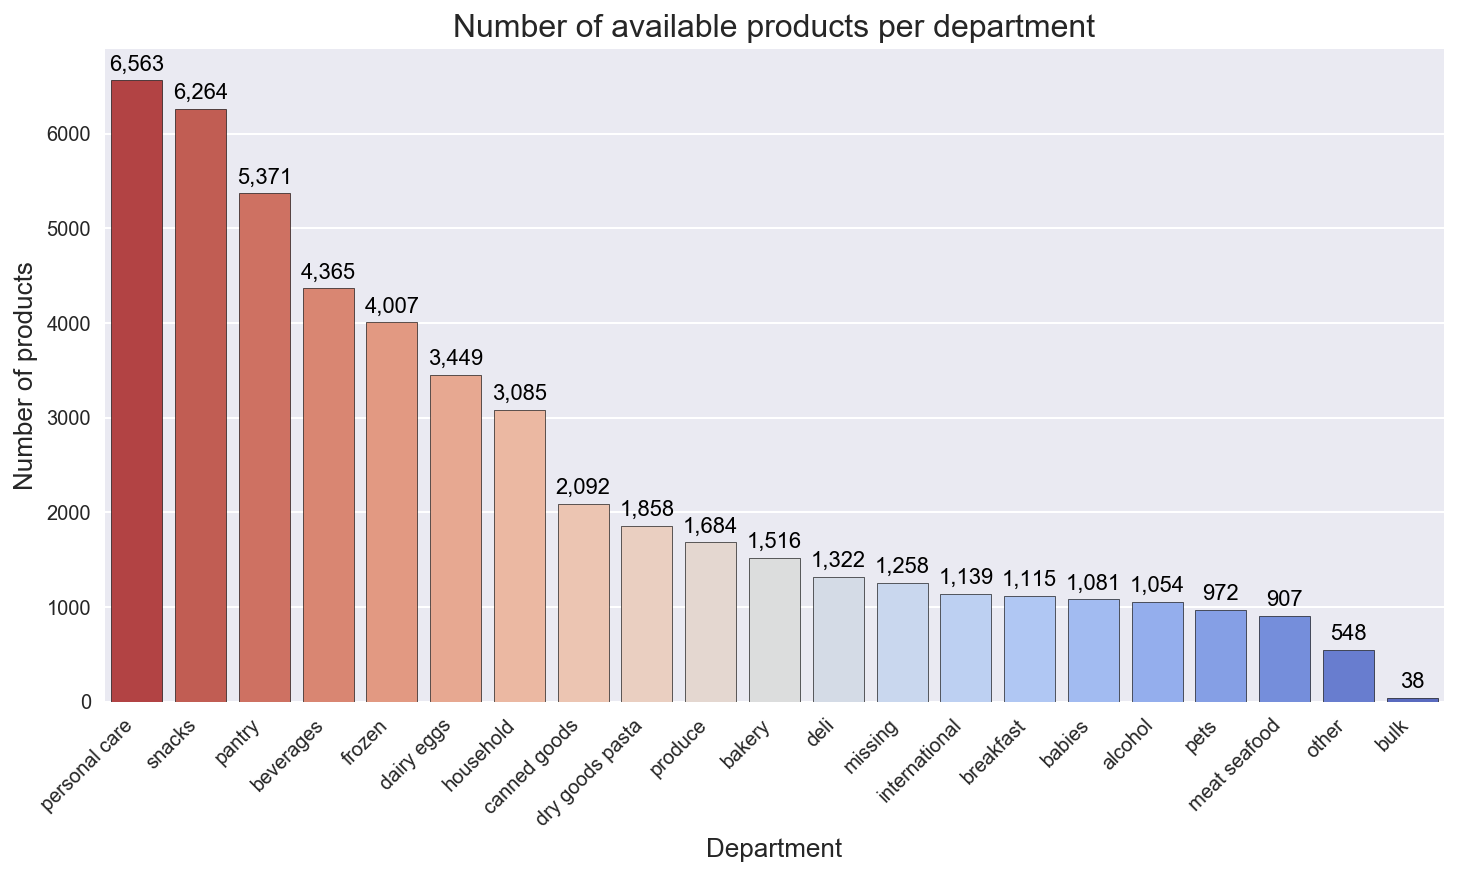

In [9]:
plt.figure(figsize=(12,6))
plot = sns.countplot(
    products['department'], 
    palette='coolwarm_r', 
    edgecolor='black',
    order=products['department'].value_counts().index)
display_count(plot, '{:,.0f}', 11)
plt.xticks(rotation=45, ha='right')
plt.title('Number of available products per department', fontdict={'fontsize':16})
plt.xlabel('Department', fontdict={'fontsize':13})
plt.ylabel('Number of products', fontdict={'fontsize':13})
plt.show()

The chart above shows the available products sold by the store, divided into individual departments. The division into aisle is too large to be readable on the chart. Above you can see that the most available products are in the 'personal care', 'snacks' and 'pantry' categories. The smallest number of products available is in the seafood and pets department (apart from 'other' and 'bulk').

Next, by combining the above products table and the main df table (which contains information about the products added to the cart), the orders_prod table will be created.

In [10]:
orders_prod = pd.merge(df, products, left_on='product_id', right_index=True)
orders_prod.drop(['product_id'], axis=1, inplace=True)
orders_prod.sort_index(inplace=True)

orders_prod['add_to_cart_order'] = orders_prod['add_to_cart_order'].astype('int16')
orders_prod['reordered'] = orders_prod['reordered'].astype('boolean')

orders_prod.head()

add_to_cart_order  reordered        product_name  \
order_id                                                     
2                         1       True  Organic Egg Whites   
2                         4       True      Coconut Butter   
2                         5      False   Natural Sweetener   
2                         6       True             Carrots   
2                         3      False       Garlic Powder   

                       aisle  department  
order_id                                  
2                       eggs  dairy eggs  
2              oils vinegars      pantry  
2         baking ingredients      pantry  
2           fresh vegetables     produce  
2          spices seasonings      pantry

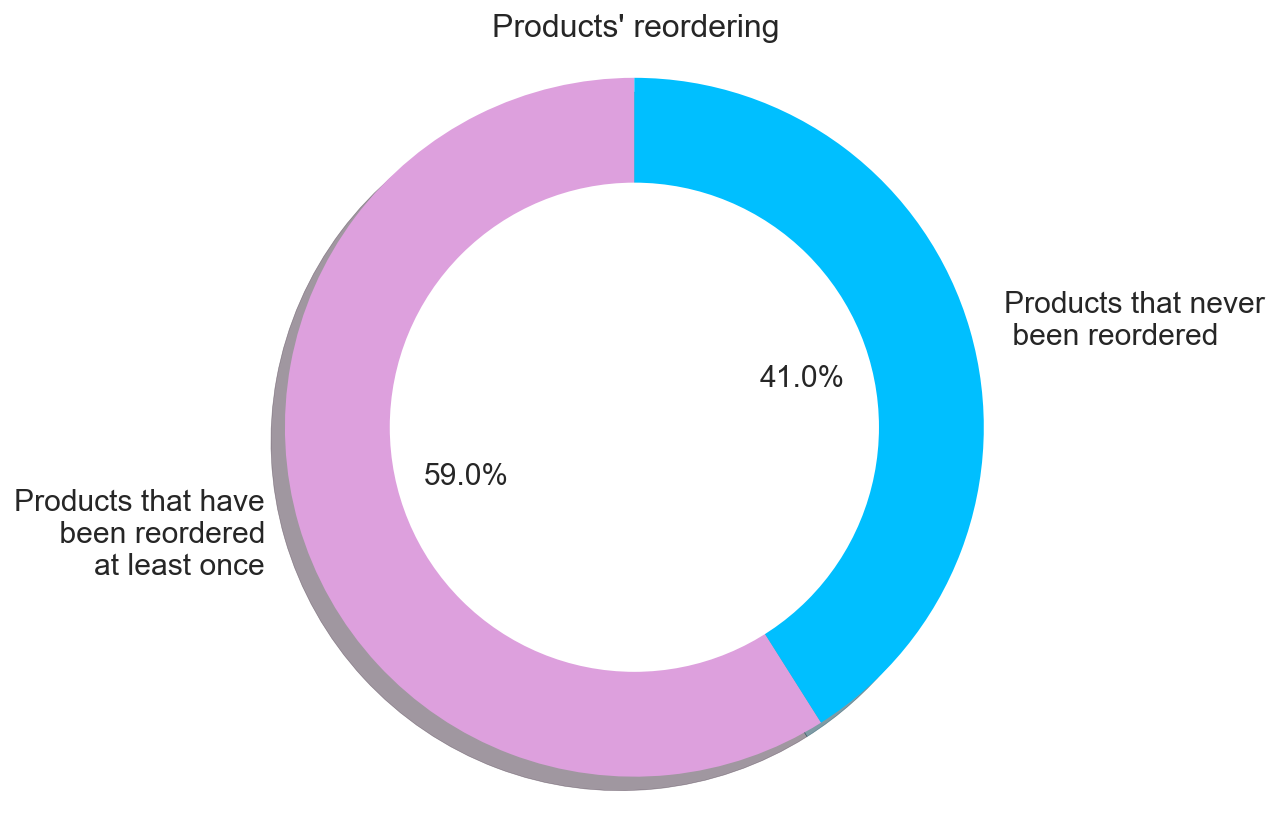

In [11]:
plt.figure(figsize=(7,7))
plt.pie(
    orders_prod['reordered'].value_counts(), 
    labels=['Products that have\n been reordered\nat least once', 'Products that never\n been reordered'],
    colors=['plum', 'deepskyblue'],
    autopct='%.1f%%',
    pctdistance=.5,
    startangle=90,
    textprops={'fontsize': 15},
    shadow=True)

centre_circle = plt.Circle((0,0), .7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title("Products' reordering", fontdict={'fontsize':16})
plt.show()  

The chart above shows that most of the products were ordered again at least once. However, this is not a good result - as much as 41% of all products were bought only once. Some of them may result from the self-characteristics of the product, which does not have to be bought more than once every few months, but for another part it may mean that the quality of these products was insufficient for customers and they do not want to buy them again. Although the quality of the products is independent of the retail store, the sale of low-quality products can affect the reputation of the store and cause the outflow of customers to the competition.

Next, an information on the best and worst-selling product categories (by aisle) will be prepared.

In [12]:
aisle_pop = orders_prod['aisle'].value_counts()/orders_prod['aisle'].value_counts().sum()
aisle_pop

fresh fruits                 0.11229
fresh vegetables             0.10538
packaged vegetables fruits   0.05443
yogurt                       0.04478
packaged cheese              0.03021
                               ...  
eye ear care                 0.00028
baby bath body care          0.00026
baby accessories             0.00025
beauty                       0.00019
frozen juice                 0.00015
Name: aisle, Length: 134, dtype: float64

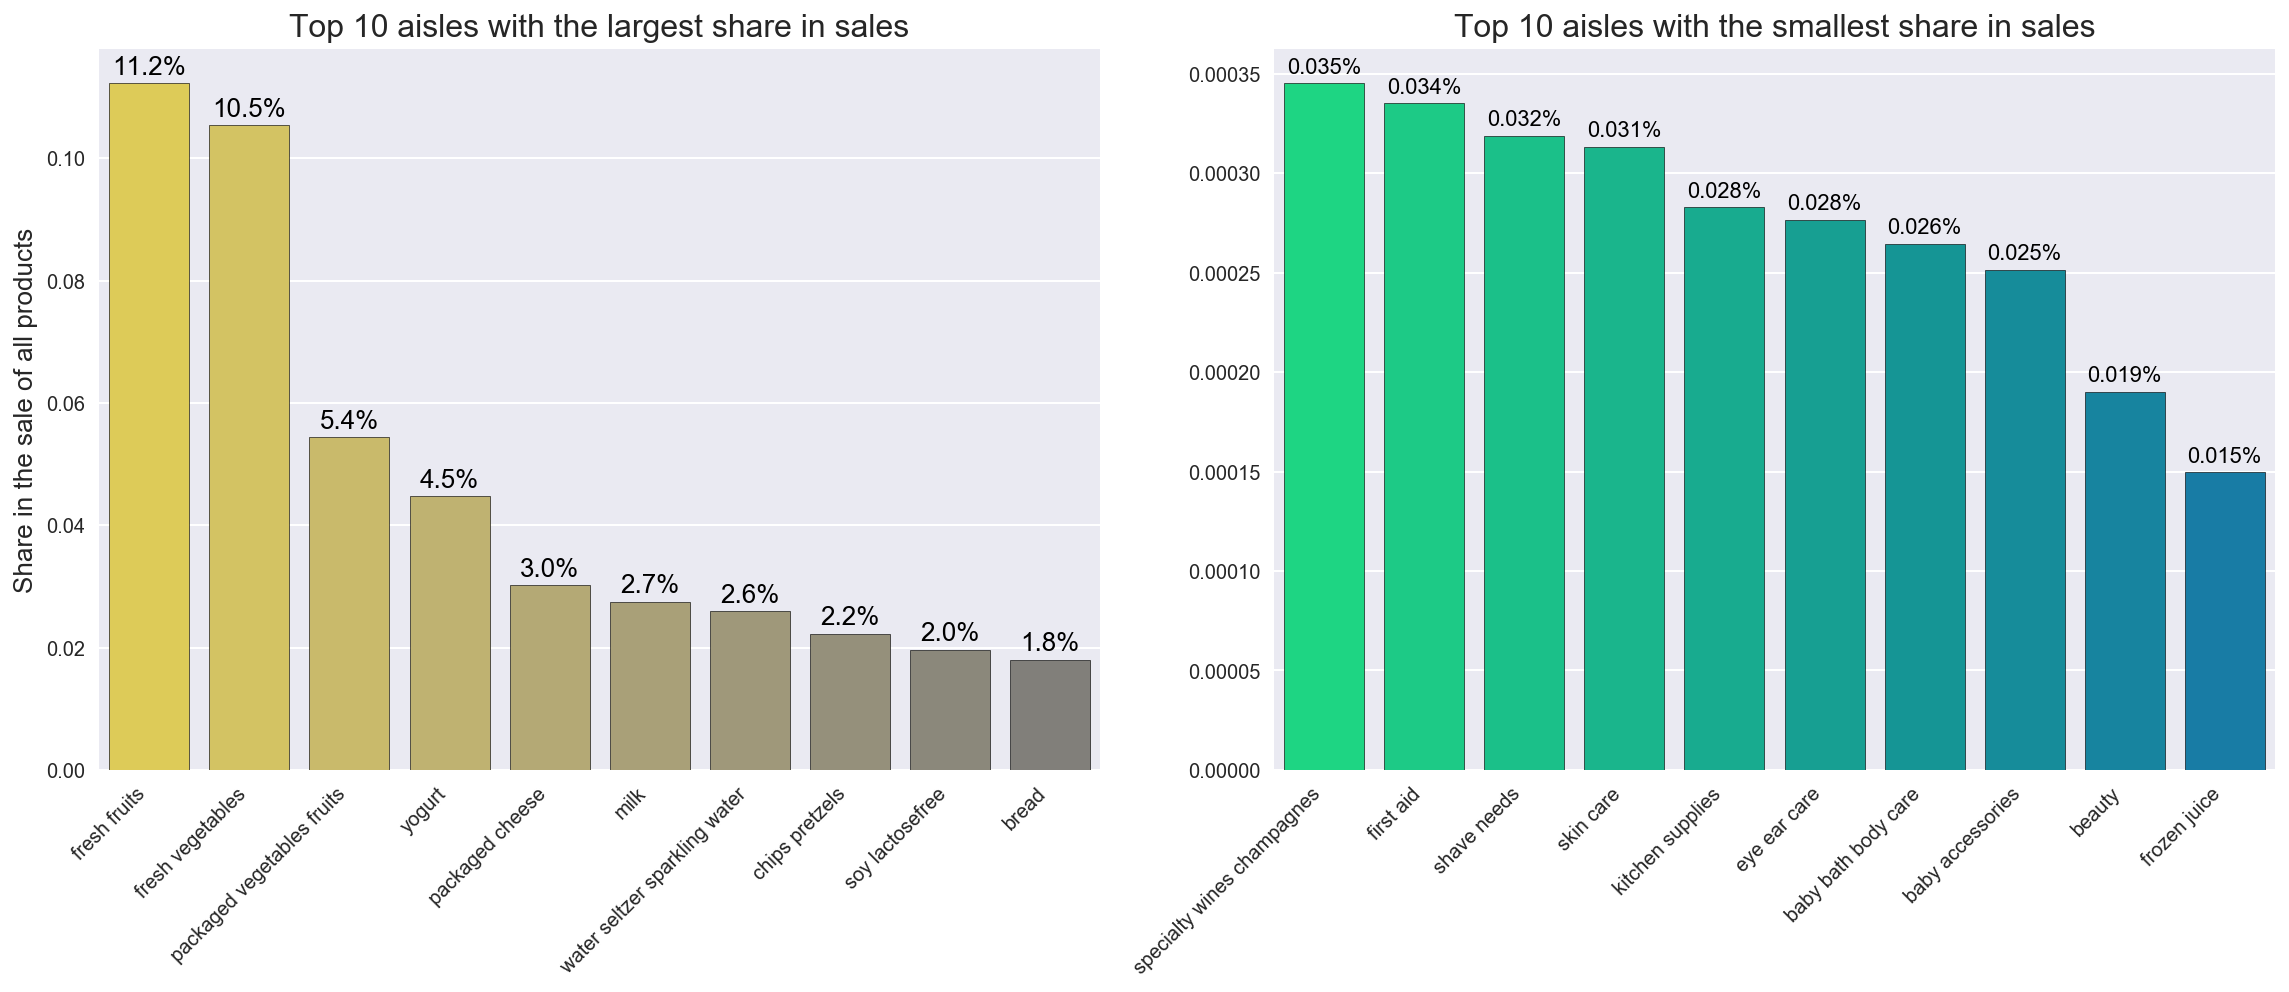

In [13]:
plt.figure(figsize=(16,7))

plt.subplot(121)
plot=sns.barplot(
    x=aisle_pop.index[:10], 
    y=aisle_pop[:10], 
    edgecolor='black', 
    palette=sns.color_palette('cividis_r', 20))
display_count(plot, '{:.1%}', 13, rnd=3)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 aisles with the largest share in sales', fontdict={'fontsize':16})
plt.xlabel('')
plt.ylabel('Share in the sale of all products', fontdict={'fontsize':13})

plt.subplot(122)
plot=sns.barplot(
    x=aisle_pop.index[-10:], 
    y=aisle_pop[-10:], 
    edgecolor='black', 
    palette=sns.color_palette('winter_r', 20))
display_count(plot, '{:.3%}', 11, rnd=5)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 aisles with the smallest share in sales', fontdict={'fontsize':16})
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

Both charts above show the best- and the worst-selling product categories broken down by aisles. The left chart shows that fresh fruit is responsible for over 11% of all products sold. Fresh vegetables are not much worse, share smaller only by 0.7%. This indicates that people who shop regularly may be responsible for a large proportion of customers - such people must order food quite often. 

On the other hand, the right chart shows that the least popular product category are 'beauty' and 'frozen juice' - considering this, the company can think about whether it is rational to continue selling these products in present form - it may be necessary to increase the possible assortment of these categories or increase their visibility on the website.

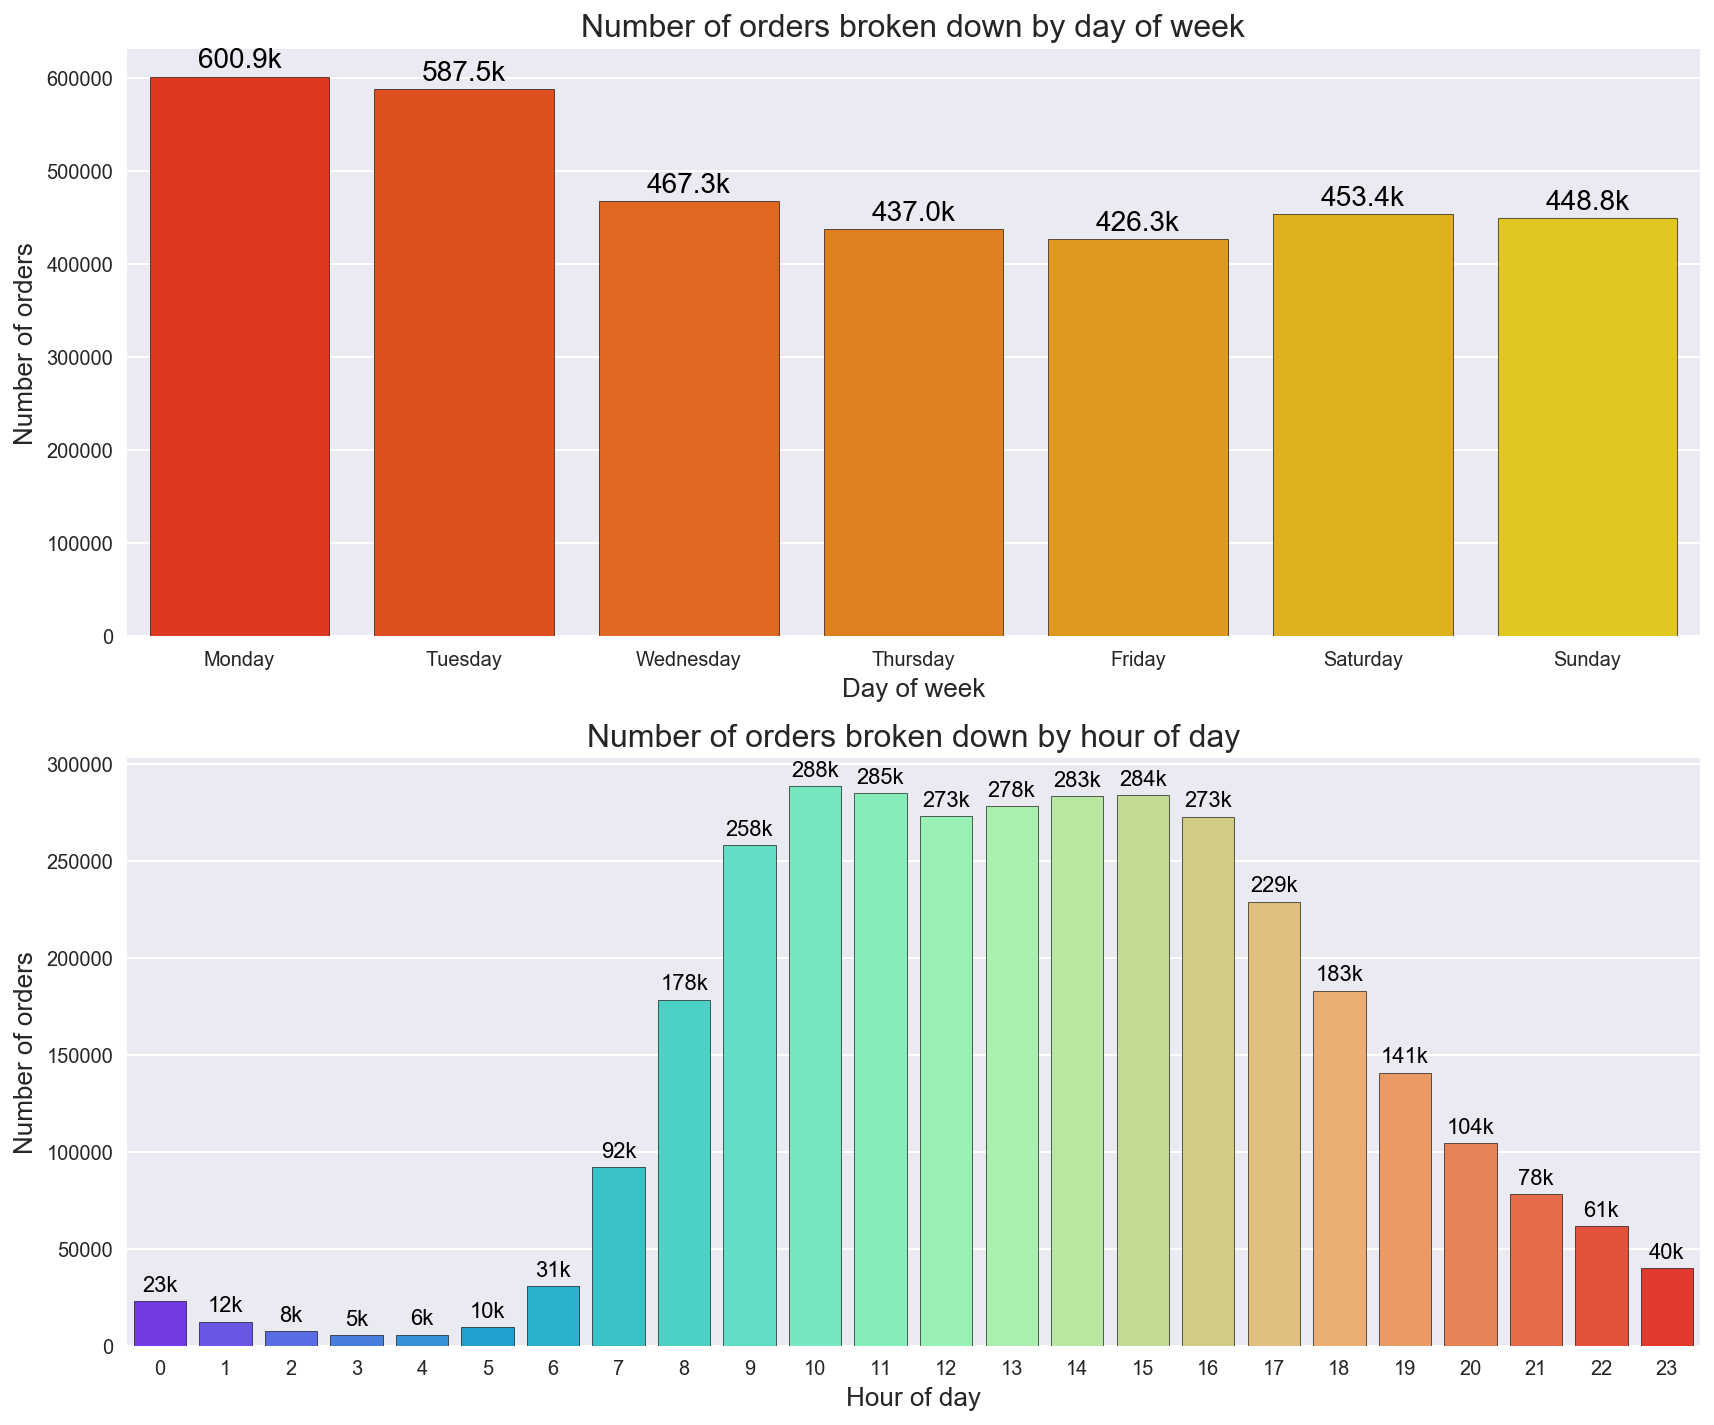

In [14]:
plt.figure(figsize=(12,10))

plt.subplot(211)
plot = sns.countplot(orders['order_dow'], edgecolor='black', palette='autumn')
display_count(plot, '{:.1f}k', size=14, div=1000, rnd=2)
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of orders broken down by day of week', fontdict={'fontsize':16})
plt.xlabel('Day of week', fontdict={'fontsize':13})
plt.ylabel('Number of orders', fontdict={'fontsize':13})

plt.subplot(212)
plot = sns.countplot(orders['order_hour_of_day'], edgecolor='black', palette='rainbow')
display_count(plot, '{:.0f}k', size=11, div=1000)
plt.title('Number of orders broken down by hour of day', fontdict={'fontsize':16})
plt.xlabel('Hour of day', fontdict={'fontsize':13})
plt.ylabel('Number of orders', fontdict={'fontsize':13})

plt.tight_layout()
plt.show()

Another thing that may be checked easily is the time and day when the orders are usually placed.When it comes to the day of the week there are no significant differences - it is easy to see that most orders are placed on Monday and Tuesday, but the diffrence is not that significant. It is probable that some customers are used to place orders regullary at the beginning of the week to secure the needs of grocery and to no longer worry about this problem.

In the case of the hour, it is not surprising that almost all orders are placed during the day and not at night. What is puzzling is that most orders are placed between 9am and 4pm - in the business hours. One may think that usually most orders in online shops are placed in the evening, after finishing work. This suggests that perhaps some of the customers may be companies (despite the fact that Instacart operates in retail trade) that place orders during their working hours. It is also possible that thanks to a simple smartphone app, placing orders is so easy that it is carried out during business hours, for example during lunch break.

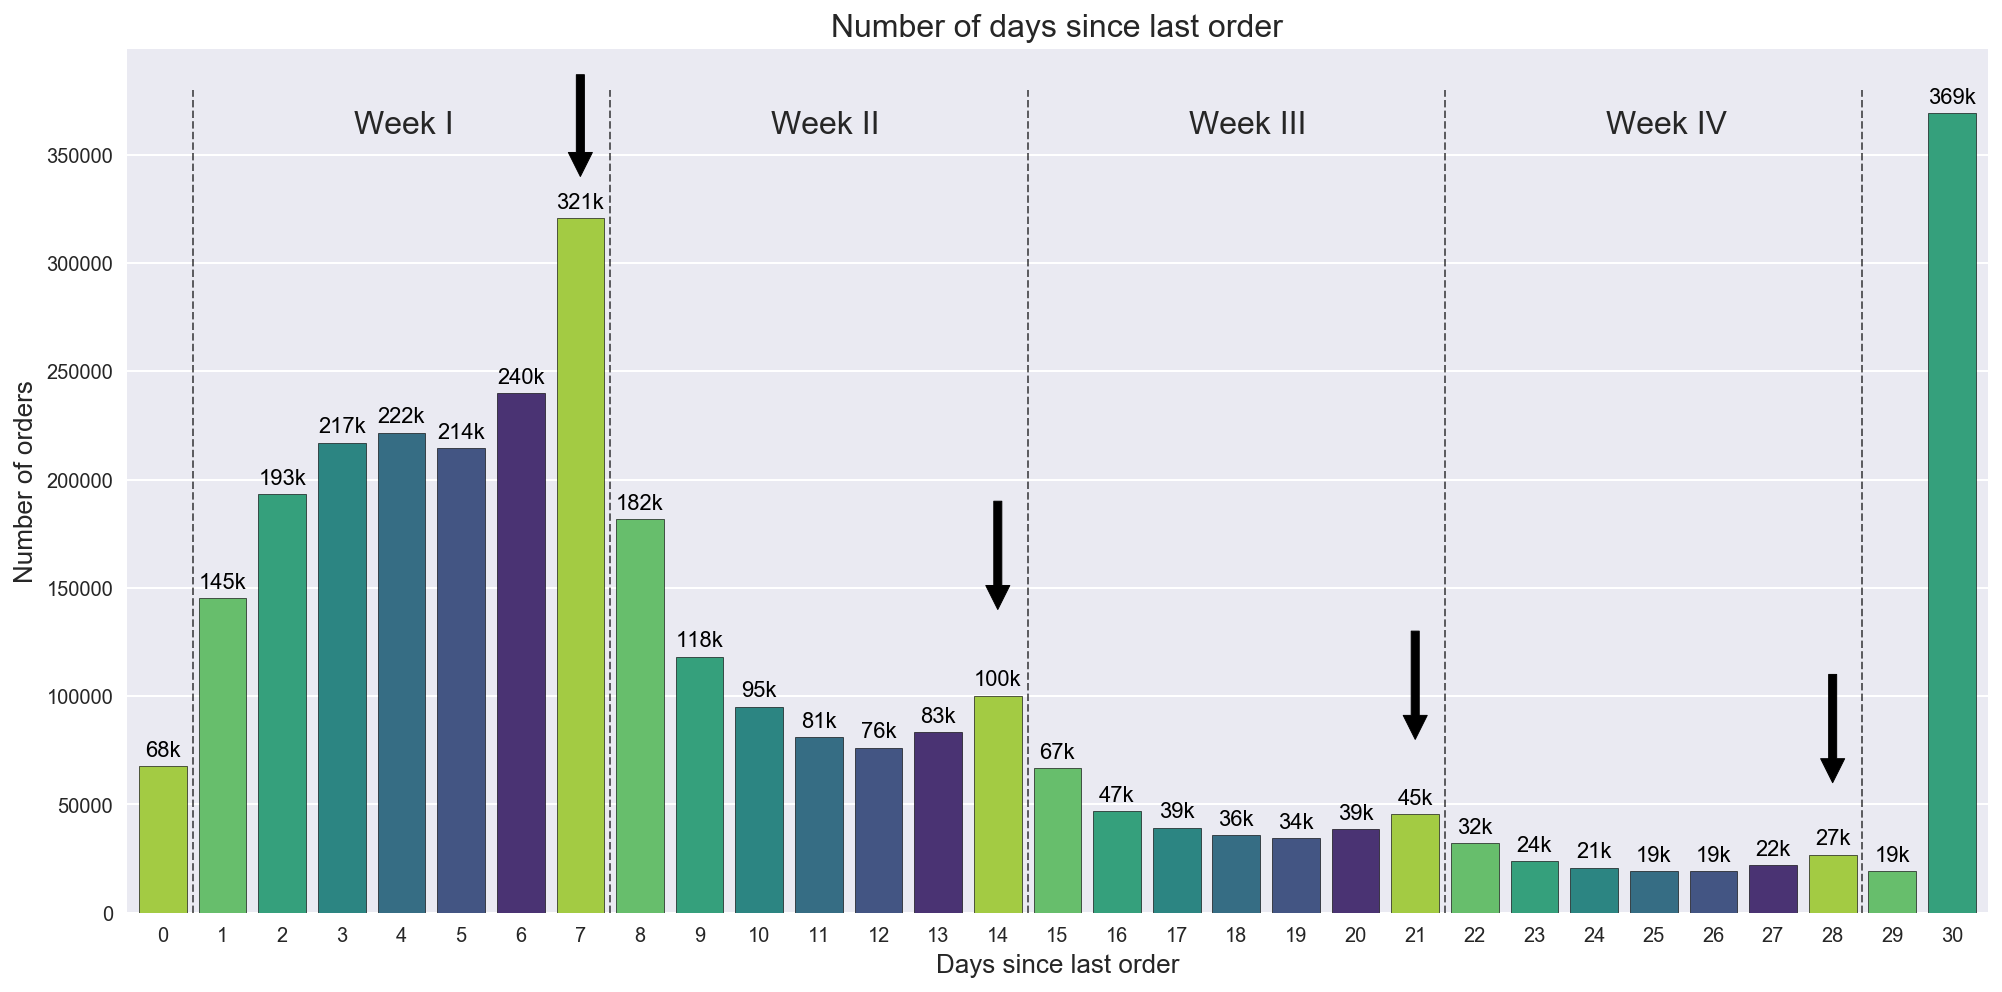

In [15]:
plt.figure(figsize=(14,7))
plot = sns.countplot(
    orders.dropna()['days_since_prior_order'].astype('int8'),
    edgecolor='black',
    palette=sns.color_palette('viridis_r', 7),
    saturation=.8)

display_count(plot, '{:.0f}k', size=11, div=1000)

plt.annotate(s='', xytext=(7, 387000), xy=(7, 340000),
             arrowprops={'lw': 0.5, 'color': 'black'})
plt.annotate(s='', xytext=(14, 190000), xy=(14, 140000),
             arrowprops={'lw': 0.5, 'color': 'black'})
plt.annotate(s='', xytext=(21, 130000), xy=(21, 80000),
             arrowprops={'lw': 0.5, 'color': 'black'})
plt.annotate(s='', xytext=(28, 110000), xy=(28, 60000),
             arrowprops={'lw': 0.5, 'color': 'black'})

plt.vlines(x=[0.5, 7.5, 14.5, 21.5, 28.5], ymin=0, ymax=380000, ls='--', lw=1, alpha=.6)

plt.annotate(s='Week I', xy=(3.2, 360000), size=16)
plt.annotate(s='Week II', xy=(10.2, 360000), size=16)
plt.annotate(s='Week III', xy=(17.2, 360000), size=16)
plt.annotate(s='Week IV', xy=(24.2, 360000), size=16)

plt.title('Number of days since last order', fontdict={'fontsize':16})
plt.xlabel('Days since last order', fontdict={'fontsize':13})
plt.ylabel('Number of orders', fontdict={'fontsize':13})
plt.xlim(-0.6,30.6)
plt.tight_layout()
plt.show()

The chart above shows how the number of days between the individual orders is arranged. What is visible at first is a disproportionately high 30-day value bar. This probably means not '*30 days*' but rather '*30 days and more*', hence such a big difference.

Another issue is the increase of orders on the day being 7, 14, 21 and 28 days since the last order (marked with a black arrow). This indicates that a large number of customers shop at regular weekly intervals. In addition, to illustrate these weekly intervals, the days were divided by dashed lines into four weeks - it can be seen that in each of them the middle of the week has a visibly lower number of orders than its beginning and end.

Finally, it can be mentioned that the data contained information about 68k "forgetful" customers who placed more than one order on the same day.

In the next step, data will be prepared to extract the sum of the number of orders placed by individual customers.

In [16]:
orders['user_id'].value_counts()

53684     100
201623    100
50817     100
176951    100
88911     100
         ... 
24224       4
199509      4
32420       4
21310       4
196830      4
Name: user_id, Length: 206209, dtype: int64

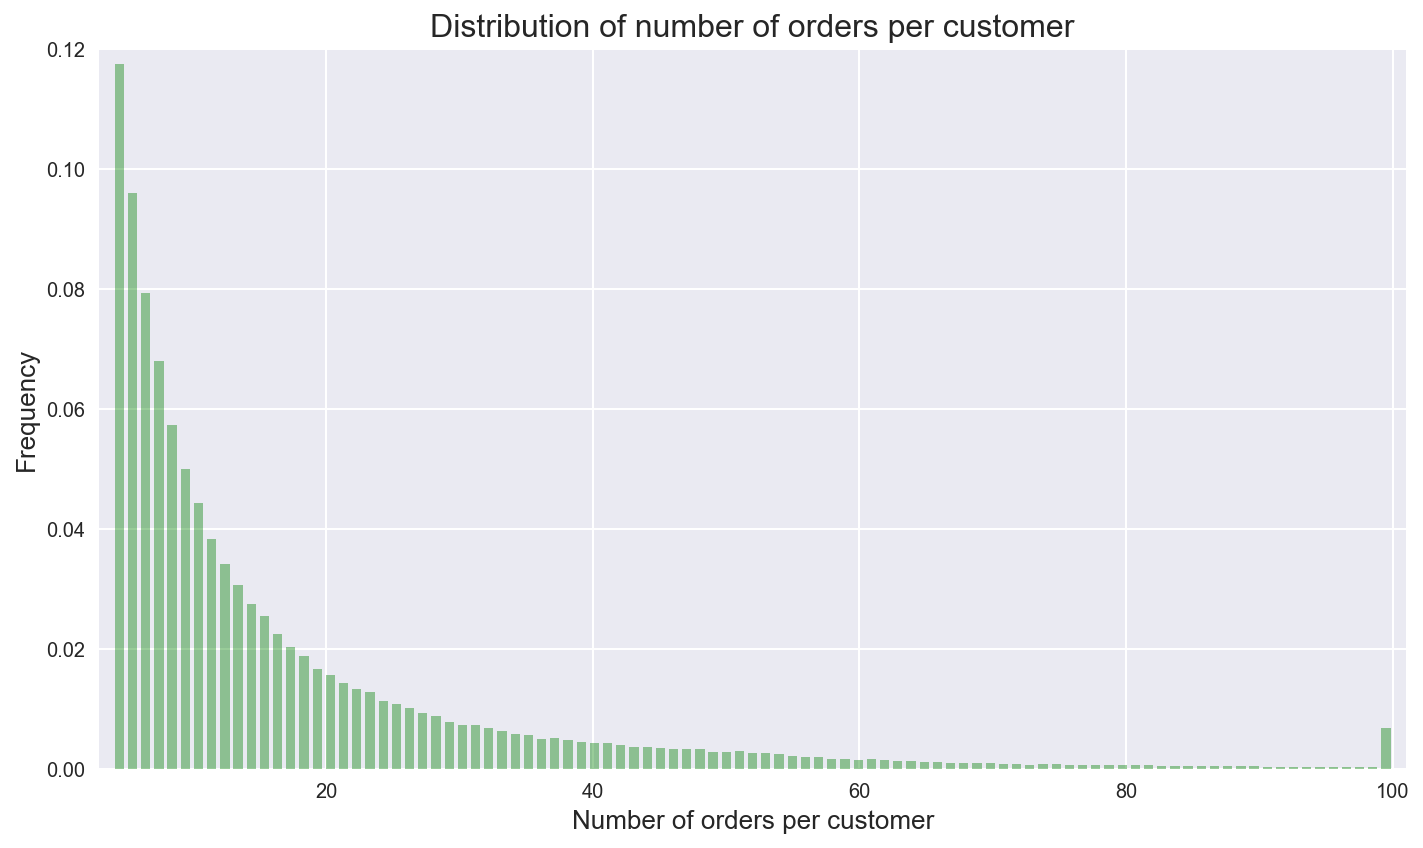

In [17]:
plt.figure(figsize=(10,6))
plot = sns.distplot(
    orders['user_id'].value_counts(), 
    bins=97, 
    kde=False,
    norm_hist=True,
    color='green',
    hist_kws={"rwidth":.7})
plt.title('Distribution of number of orders per customer', fontdict={'fontsize':16})
plt.xlabel('Number of orders per customer', fontdict={'fontsize':13})
plt.ylabel('Frequency', fontdict={'fontsize':13})
plt.xlim(3,101)
plt.ylim(0,.12)
plt.tight_layout()
plt.show()

The first thing to highlight is, as before, the question of maximum value. According to the data, there are disproportionately more customers who placed 100 orders than those who only placed 99. Also the number 100 is the maximum value. Thus, one can come to a conclusion that the store has somehow limited data and does not record more than 100 transactions per customer. What's more, the smallest value is 4 - in the dataset each customer has made at least 4 orders.

Excluding the above, the rest of the data seems to make the most sense - the bigger number of orders per customers, the less such customers there are. Most are customers who have placed less than 10 orders.

In the next step data will be grouped in such a way that it is easy to check the characteristics of each individual product.

In [18]:
products_pop = orders_prod.groupby('product_name').agg({
    'product_name':'count',
    'reordered': 'sum',
    'add_to_cart_order': 'mean',
    'aisle': pd.Series.mode,
    'department': pd.Series.mode})

products_pop.rename({'product_name': 'no_purchases'}, axis=1, inplace=True)

products_pop['aisle'] = products_pop['aisle'].astype('category')
products_pop['department'] = products_pop['department'].astype('category')
products_pop['no_purchases'] = products_pop['no_purchases'].astype('int32')
products_pop['reordered'] = products_pop['reordered'].astype('int32')

products_pop.head()

no_purchases  reordered  \
product_name                                                      
#2 Coffee Filters                                777        257   
#2 Cone White Coffee Filters                      13          3   
#2 Mechanical Pencils                              8          0   
#4 Natural Brown Coffee Filters                  241         89   
& Go! Hazelnut Spread + Pretzel Sticks           164         87   

                                        add_to_cart_order           aisle  \
product_name                                                                
#2 Coffee Filters                                 9.25740          coffee   
#2 Cone White Coffee Filters                      7.38462          coffee   
#2 Mechanical Pencils                             7.75000  more household   
#4 Natural Brown Coffee Filters                  10.70124          coffee   
& Go! Hazelnut Spread + Pretzel Sticks           11.55488         spreads   

                                       department  
product_name                                       
#2 Coffee Filters                       beverages  
#2 Cone White Coffee Filters            beverages  
#2 Mechanical Pencils                   household  
#4 Natural Brown Coffee Filters         beverages  
& Go! Hazelnut Spread + Pretzel Sticks     pantry

The new table specifies how many times a particular product was purchased, how many times it was ordered again by the same customer and the information on whether the product is added to the basket statistically as one of the first or last products.

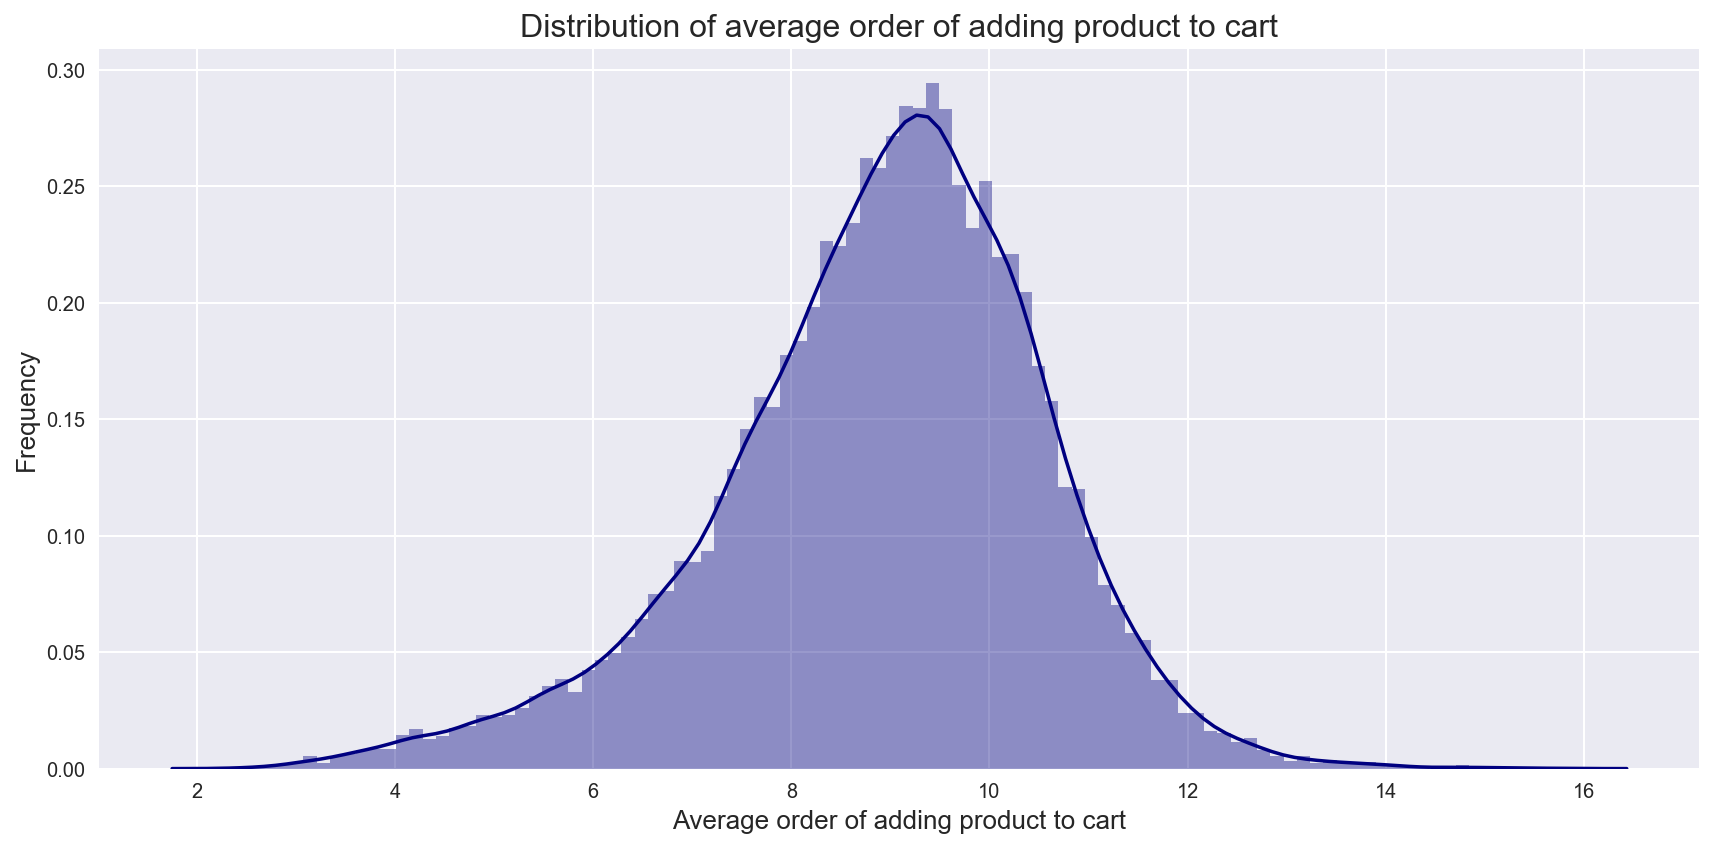

In [19]:
plt.figure(figsize=(12,6))
plot = sns.distplot(
    products_pop[products_pop['no_purchases'] > 100]['add_to_cart_order'], 
    bins=100,
    color='navy')
plt.title('Distribution of average order of adding product to cart', fontdict={'fontsize':16})
plt.xlabel('Average order of adding product to cart', fontdict={'fontsize':13})
plt.ylabel('Frequency', fontdict={'fontsize':13})
plt.tight_layout()
plt.show()

As can be seen in the graph above, the distribution of average value is approaching the normal distribution, although it is slightly left-skewed. It is worth mentioning that the chart above shows only products that were purchased at least 100 times to filter out extreme results resulting only from accidental rare buying of products. It is hard to consider a product as often added to the basket as the first one if it was bought... only once.

The vast majority of products is added on average as 8-10 products. However more interesting are products that are bought as one of the first or one of the last. Depending on the characteristics of such a product, the company may want to plan a marketing campaigns, e.g. displaying chewing gums at the very end of the order, just before payment, to trigger an impulsive purchase from the customer.

In [20]:
products_pop['purchase_bin'] = pd.qcut(products_pop['no_purchases'], 10, labels=False)
products_pop['reorder_ratio'] = products_pop['reordered'] / products_pop['no_purchases']

products_pop = pd.merge(
    left=products_pop, 
    right=products_pop.groupby('purchase_bin').mean()['reorder_ratio'],
    left_on='purchase_bin',
    right_index=True,
    suffixes=('_general', '_bin'))

products_pop.head()

no_purchases  reordered  add_to_cart_order  \
product_name                                                                  
#2 Coffee Filters                         777        257            9.25740   
0% Fat Blueberry Greek Yogurt             529        309            8.42533   
0% Fat Superfruits Greek Yogurt           713        403            9.02945   
1 % Lowfat Milk                           888        563            6.78041   
1% Chocolate Milk                         618        450            6.33010   

                                  aisle  department  purchase_bin  \
product_name                                                        
#2 Coffee Filters                coffee   beverages             8   
0% Fat Blueberry Greek Yogurt    yogurt  dairy eggs             8   
0% Fat Superfruits Greek Yogurt  yogurt  dairy eggs             8   
1 % Lowfat Milk                    milk  dairy eggs             8   
1% Chocolate Milk                  milk  dairy eggs             8   

                                 reorder_ratio_general  reorder_ratio_bin  
product_name                                                               
#2 Coffee Filters                              0.33076            0.48939  
0% Fat Blueberry Greek Yogurt                  0.58412            0.48939  
0% Fat Superfruits Greek Yogurt                0.56522            0.48939  
1 % Lowfat Milk                                0.63401            0.48939  
1% Chocolate Milk                              0.72816            0.48939

In the next part, the number of re-orders was analyzed. Above, for each product an indicator (ratio) was created that informs how much of total orders were reordered (*reorder_ratio_general*). Comparing this ratio alone can lead to misleading conclusions - 10 categories / bins are built in the first place (*purchase_bin*) to which individual products are assigned to, based on the number of total orders. These categories (bins) were created on the basis of **deciles**. The average ratio value for each basket was also calculated (reorder_ratio_bin).

In [21]:
x = np.array(sorted(products_pop['purchase_bin'].unique()))
y = np.array(sorted(products_pop['reorder_ratio_bin'].unique()))

def draw_background():
    plt.figure(figsize=(12,8))
    plt.plot(x, y, ls='--', lw=2, c='steelblue', alpha=0.7)
    plt.plot(x, (y + y*3*np.std(y)), ls=':', alpha=0.7, c='steelblue', lw=2)
    plt.plot(x, (y - y*3*np.std(y)), ls=':', alpha=0.7, c='steelblue', lw=2)

    plt.fill_between(x, (y + y*3*np.std(y)), 1,  alpha=.3, color='limegreen')
    plt.fill_between(x, (y - y*3*np.std(y)), (y + y*3*np.std(y)),  alpha=.3, color='orange')
    plt.fill_between(x, (y - y*3*np.std(y)),  alpha=.3, color='tomato')
    
    plt.title('The distribution of products depending on their performance', fontdict={'fontsize':16})
    plt.xlim(0,9)
    plt.ylim(0,1)

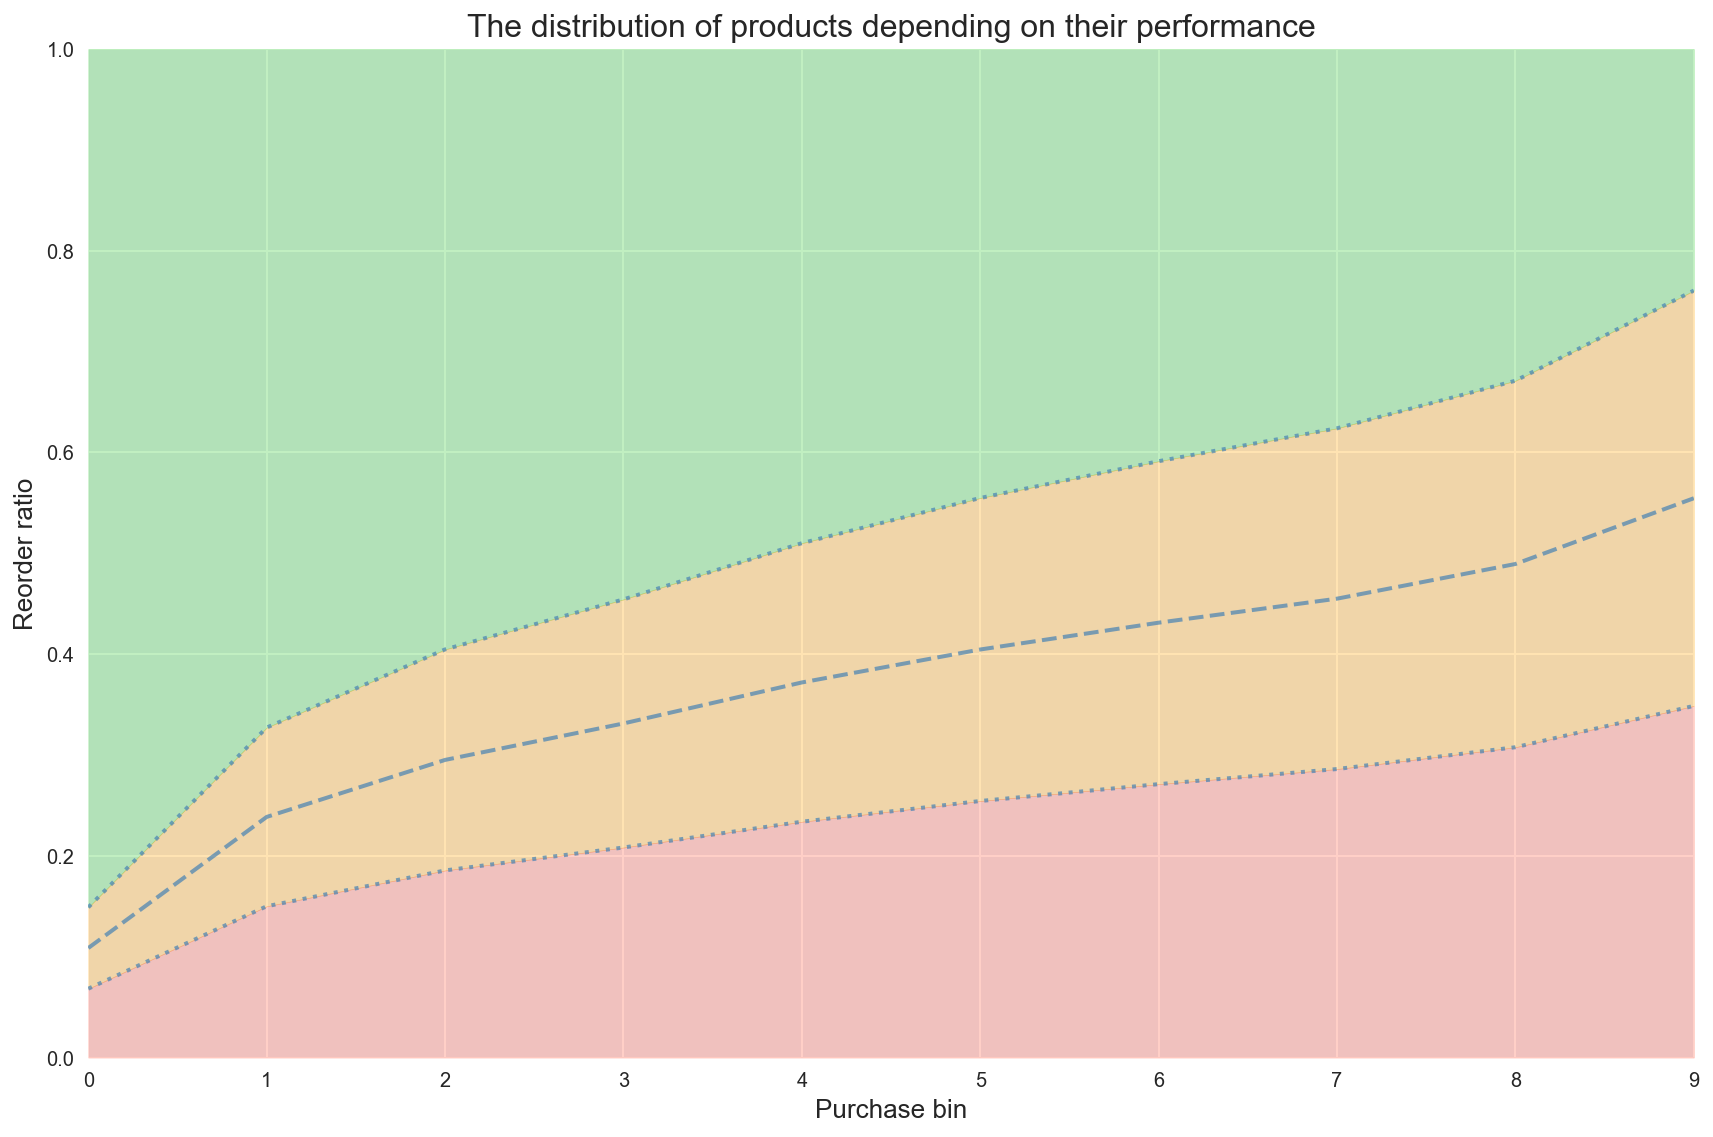

In [22]:
draw_background()
plt.xlabel('Purchase bin', fontdict={'fontsize':13})
plt.ylabel('Reorder ratio', fontdict={'fontsize':13})
plt.tight_layout()
plt.show()

Above, a part of the chart has been prepared, on which products will then be plotted to visually check how much  products are reordered in a number smaller or larger than the average for the respective bin / category. Three times the standard deviation of the basket reorder ratio was assumed as a measure of recognizing the product as performing well or badly.

Products which reorder ratio is **less** than the appropriate average by more than 3 standard deviations should be considered underperforming. In contrast, products with reorder ratio is **more** than the appropriate average by more than 3 standard deviations should be considered overperforming. The yellow range will mean a measure close to the average.

In [23]:
near_mean = products_pop['reorder_ratio_general'] >= (products_pop['reorder_ratio_bin'] 
           - 3*products_pop['reorder_ratio_bin']*products_pop['reorder_ratio_bin'].std())

below_mean = products_pop['reorder_ratio_general'] <= (products_pop['reorder_ratio_bin'] 
           - 3*products_pop['reorder_ratio_bin']*products_pop['reorder_ratio_bin'].std())

above_mean = products_pop['reorder_ratio_general'] >= (products_pop['reorder_ratio_bin'] 
           + 3*products_pop['reorder_ratio_bin']*products_pop['reorder_ratio_bin'].std())

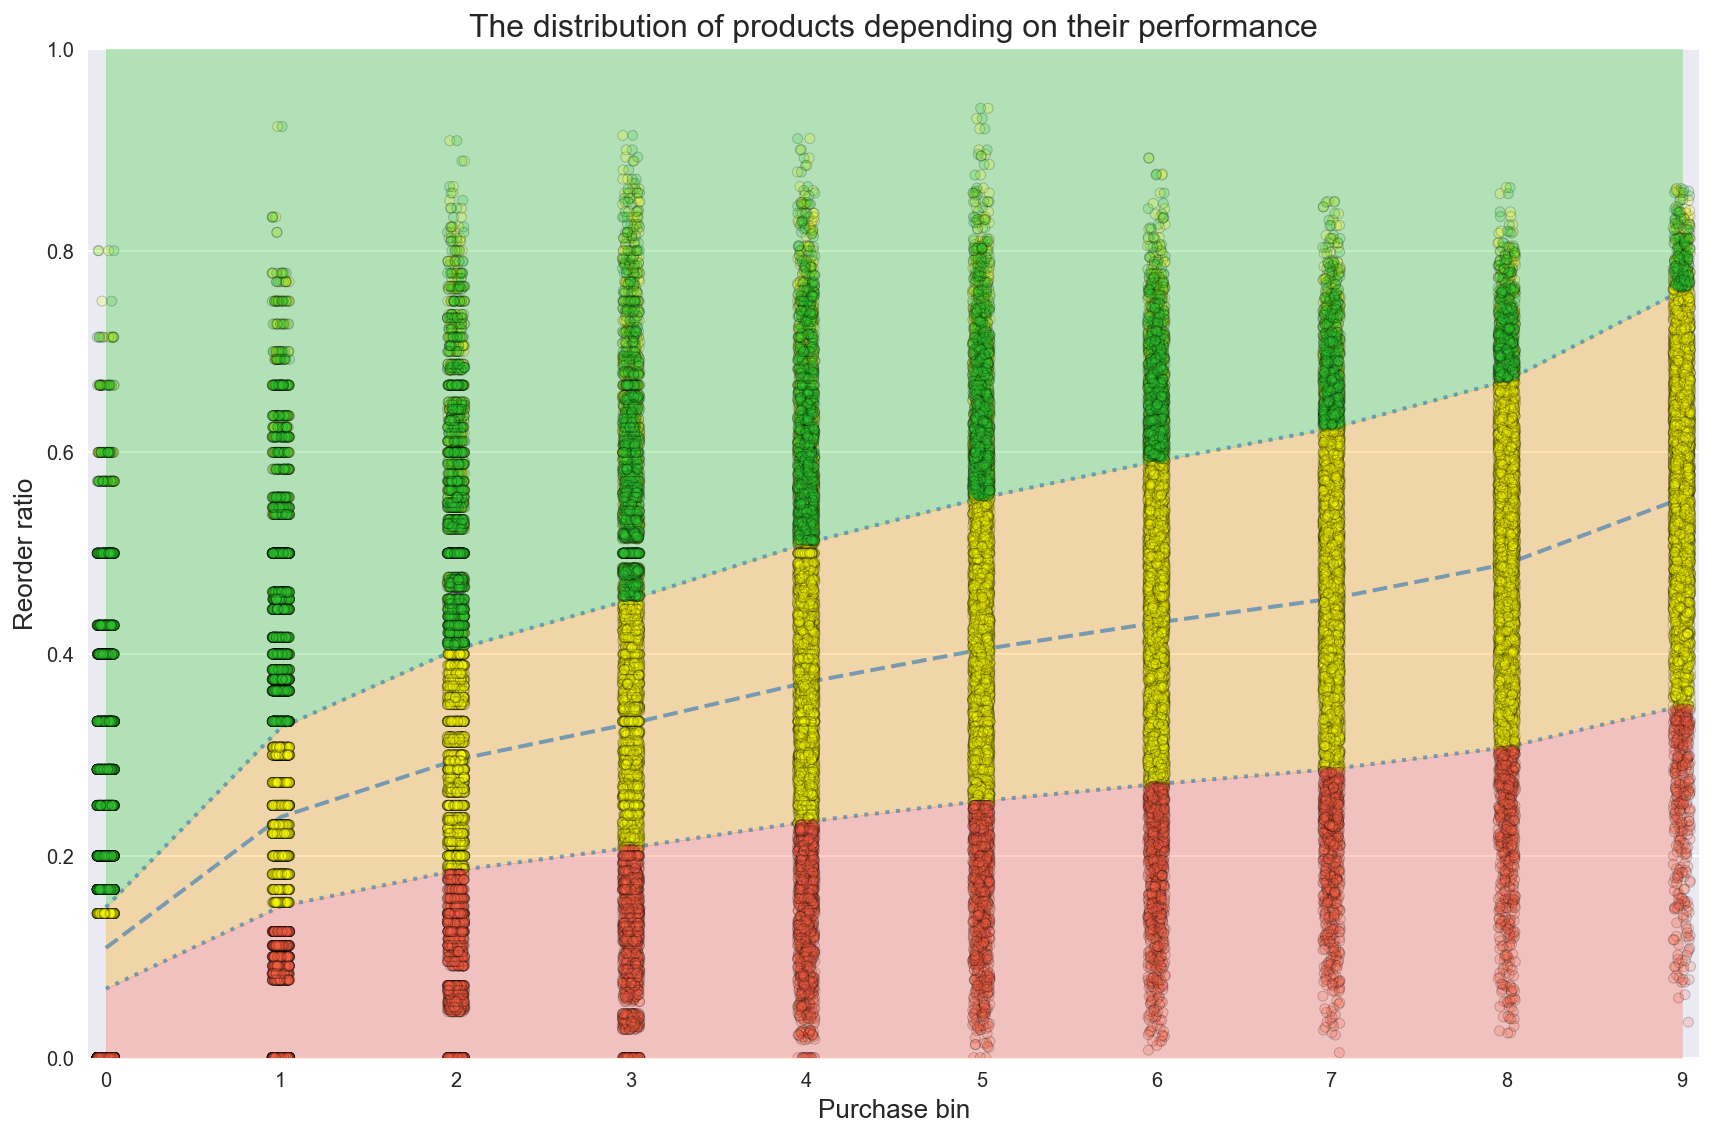

In [24]:
draw_background()
sns.stripplot(x='purchase_bin', y='reorder_ratio_general', data=products_pop[near_mean], 
    jitter=0.05, alpha=.2, color='yellow', edgecolor='black',linewidth=0.5)
sns.stripplot(x='purchase_bin', y='reorder_ratio_general', data=products_pop[above_mean], 
    jitter=0.05, alpha=.2, color='limegreen', edgecolor='black',linewidth=0.5)
sns.stripplot(x='purchase_bin', y='reorder_ratio_general', data=products_pop[below_mean], 
    jitter=0.05, alpha=.2, color='tomato', edgecolor='black',linewidth=0.5)
plt.xlim(-0.1,9.1)
plt.xlabel('Purchase bin', fontdict={'fontsize':13})
plt.ylabel('Reorder ratio', fontdict={'fontsize':13})
plt.tight_layout()
plt.show()

As presented in the chart above, red dots symbolize products that are ordered less often than their counterparts from a given basket. Unfortunataly, the number of available products is so big that the chart in the standard, non-interactive form is illegible - it is difficult to see if there are more products that sell extremely well or badly. In this case, additional filtering is required to check the detailed information.

In [25]:
products_pop[(below_mean) &
             (products_pop['department'] == 'dairy eggs') &
             (products_pop['no_purchases'] > 50)].sort_values('reorder_ratio_general').head()

no_purchases  reordered  \
product_name                                                                
Vegan Egg Substitute Mix                                    78          6   
Organic Cooked Vanilla Pudding & Pie Filling Mix           233         29   
Romano Cheese Wedge                                         70          9   
Egg Replacer                                               154         20   
Sharp Extra Light Cheddar Cheese                            58          8   

                                                  add_to_cart_order  \
product_name                                                          
Vegan Egg Substitute Mix                                   12.38462   
Organic Cooked Vanilla Pudding & Pie Filling Mix           11.52790   
Romano Cheese Wedge                                         9.85714   
Egg Replacer                                                9.20779   
Sharp Extra Light Cheddar Cheese                            9.34483   

                                                                          aisle  \
product_name                                                                      
Vegan Egg Substitute Mix                                        soy lactosefree   
Organic Cooked Vanilla Pudding & Pie Filling Mix  refrigerated pudding desserts   
Romano Cheese Wedge                                           specialty cheeses   
Egg Replacer                                                               eggs   
Sharp Extra Light Cheddar Cheese                                packaged cheese   

                                                  department  purchase_bin  \
product_name                                                                 
Vegan Egg Substitute Mix                          dairy eggs             5   
Organic Cooked Vanilla Pudding & Pie Filling Mix  dairy eggs             7   
Romano Cheese Wedge                               dairy eggs             5   
Egg Replacer                                      dairy eggs             6   
Sharp Extra Light Cheddar Cheese                  dairy eggs             4   

                                                  reorder_ratio_general  \
product_name                                                              
Vegan Egg Substitute Mix                                        0.07692   
Organic Cooked Vanilla Pudding & Pie Filling Mix                0.12446   
Romano Cheese Wedge                                             0.12857   
Egg Replacer                                                    0.12987   
Sharp Extra Light Cheddar Cheese                                0.13793   

                                                  reorder_ratio_bin  
product_name                                                         
Vegan Egg Substitute Mix                                    0.40460  
Organic Cooked Vanilla Pudding & Pie Filling Mix            0.45500  
Romano Cheese Wedge                                         0.40460  
Egg Replacer                                                0.43119  
Sharp Extra Light Cheddar Cheese                            0.37193

Here, for example, by applying the following filters:

- products from 'dairy eggs' department,
- total orders more than 50

top 5 products with the **worst reorder ratio** were displayed. One can see that for example *Organic Cooked Vanilla Pudding & Pie Filling Mix* was purchased 233 times, but reordered only 29 times. Another example is presented below.

In [26]:
products_pop[(products_pop['purchase_bin'] == 8)].sort_values('reorder_ratio_general', ascending=False).head()

no_purchases  reordered  \
product_name                                                           
Real2 Alkalized Water 500 ml                          451        389   
Lo-Carb Energy Drink                                  467        400   
Alkalized Water                                       582        488   
Purified Alkalkine Water with Minerals pH10           728        607   
Alkaline Water                                        568        469   

                                             add_to_cart_order  \
product_name                                                     
Real2 Alkalized Water 500 ml                           5.43237   
Lo-Carb Energy Drink                                   3.15203   
Alkalized Water                                        5.67354   
Purified Alkalkine Water with Minerals pH10            4.23489   
Alkaline Water                                         4.41725   

                                                                     aisle  \
product_name                                                                 
Real2 Alkalized Water 500 ml                 water seltzer sparkling water   
Lo-Carb Energy Drink                                  energy sports drinks   
Alkalized Water                              water seltzer sparkling water   
Purified Alkalkine Water with Minerals pH10  water seltzer sparkling water   
Alkaline Water                               water seltzer sparkling water   

                                            department  purchase_bin  \
product_name                                                           
Real2 Alkalized Water 500 ml                 beverages             8   
Lo-Carb Energy Drink                         beverages             8   
Alkalized Water                              beverages             8   
Purified Alkalkine Water with Minerals pH10  beverages             8   
Alkaline Water                               beverages             8   

                                             reorder_ratio_general  \
product_name                                                         
Real2 Alkalized Water 500 ml                               0.86253   
Lo-Carb Energy Drink                                       0.85653   
Alkalized Water                                            0.83849   
Purified Alkalkine Water with Minerals pH10                0.83379   
Alkaline Water                                             0.82570   

                                             reorder_ratio_bin  
product_name                                                    
Real2 Alkalized Water 500 ml                           0.48939  
Lo-Carb Energy Drink                                   0.48939  
Alkalized Water                                        0.48939  
Purified Alkalkine Water with Minerals pH10            0.48939  
Alkaline Water                                         0.48939

By filtering products from only one category / bin (in this case from bin No. 8), the top 5 products with the highest reorder ratio are presented. For example, 'Lo-Carb Energy Drink' was ordered 467 times and from this up to 400 times by the same customers.

In [27]:
uderperform = pd.merge(
    products_pop['department'].value_counts(), 
    products_pop[(below_mean)]['department'].value_counts(),
    left_index=True, 
    right_index=True)
uderperform.rename({'department_x':'product_count',
                    'department_y':'products_underperformed'},
                   axis=1, inplace=True)
uderperform['underperform_ratio'] = uderperform['products_underperformed'] / uderperform['product_count']
uderperform.sort_values('underperform_ratio', ascending=False)

product_count  products_underperformed  underperform_ratio
pantry                    5370                     2721             0.50670
personal care             6563                     3145             0.47920
household                 3083                     1467             0.47584
other                      548                      258             0.47080
international             1139                      481             0.42230
missing                   1255                      487             0.38805
bulk                        38                       10             0.26316
dry goods pasta           1858                      411             0.22121
canned goods              2092                      460             0.21989
produce                   1684                      300             0.17815
babies                    1081                      176             0.16281
alcohol                   1054                      164             0.15560
meat seafood               907                      122             0.13451
beverages                 4363                      526             0.12056
snacks                    6263                      744             0.11879
frozen                    4007                      471             0.11754
bakery                    1516                      157             0.10356
deli                      1322                      132             0.09985
dairy eggs                3448                      281             0.08150
breakfast                 1114                       90             0.08079
pets                       972                       64             0.06584

The last thing in the context of the 'reorder ratio' is a summary of which departments are doing the best and which are doing the worst. By calculating how many products of all products in the department are underperforming (*underperform_ratio*), it is possible to, for example, rank departments in order from worst to best. As can be seen above, more than half of all products in the 'pantry' department are underperforming. The least number of such products is in the 'pets' department.

## Customer segmentation

The next part of the analysis will be devoted to customer segmentation in such a way as to allow additional conclusions and benefits for the company to be drawn.

In [28]:
number_products = df.groupby('order_id').agg({
    'product_id': 'count'})
number_products.rename({'product_id': 'products_in_order'}, axis=1, inplace=True)
number_products.head()

products_in_order
order_id                   
2                         9
3                         8
4                        13
5                        26
6                         3

In this case, customers will be divided **based on the number of orders and the number of products ordered**. To achieve this, it is required to check the number of products in each order.

In [29]:
users = orders.reset_index().set_index('user_id').drop('eval_set', axis=1)
users = pd.merge(users, number_products, left_on='order_id', right_index=True)

users.head()

order_id  order_number  order_dow  order_hour_of_day  \
user_id                                                         
1         2539329             1          2                  8   
1         2398795             2          3                  7   
1          473747             3          3                 12   
1         2254736             4          4                  7   
1          431534             5          4                 15   

         days_since_prior_order  products_in_order  
user_id                                             
1                           nan                  5  
1                      15.00000                  6  
1                      21.00000                  5  
1                      29.00000                  5  
1                      28.00000                  8

A new table is created containing information about each single order. The above table is merged with the table created above (with the information on the number of products in the order). This newly created table will not be directly used for customer segmentation, but thanks to it it will be possible to properly group the data.

In [30]:
user_info = users.groupby('user_id').agg({
    'order_number': 'count',
    'order_dow': 'mean',
    'order_hour_of_day': 'mean',
    'days_since_prior_order': 'mean',
    'products_in_order': 'sum'})

user_info['order_dow'] = user_info['order_dow'].round().astype('int8')
user_info['order_hour_of_day'] = user_info['order_hour_of_day'].round().astype('int8')

user_info.rename({
    'order_number': 'total_orders',
    'order_dow': 'top_day',
    'order_hour_of_day': 'top_hour',
    'days_since_prior_order': 'mean_days_since_prior_order',
    'products_in_order': 'total_purchased_items'
}, axis=1, inplace=True)

user_info['mean_number_of_products'] = user_info['total_purchased_items'] / user_info['total_orders']

user_info.head()

total_orders  top_day  top_hour  mean_days_since_prior_order  \
user_id                                                                 
1                  10        2        10                     19.55556   
2                  14        2        11                     15.23077   
3                  12        1        16                     12.09091   
4                   5        5        13                     13.75000   
5                   4        2        16                     13.33333   

         total_purchased_items  mean_number_of_products  
user_id                                                  
1                           59                  5.90000  
2                          195                 13.92857  
3                           88                  7.33333  
4                           18                  3.60000  
5                           37                  9.25000

By appropriate grouping of data based on the user_id, it is possible to create a new table containing key data for segmentation: 
- the number of orders made by a given customer (*total_orders*), 
- the day of the week in which customer most often made purchases (*top_day*), 
- the hour when customer most often made purchases (*top_hour*), 
- the average number of days between individual orders (*mean_days_since_prior_order*), 
- total number purchased of items (*total_purchased_items*) and 
- mean number of products in one order (*mean_number_of_products*).

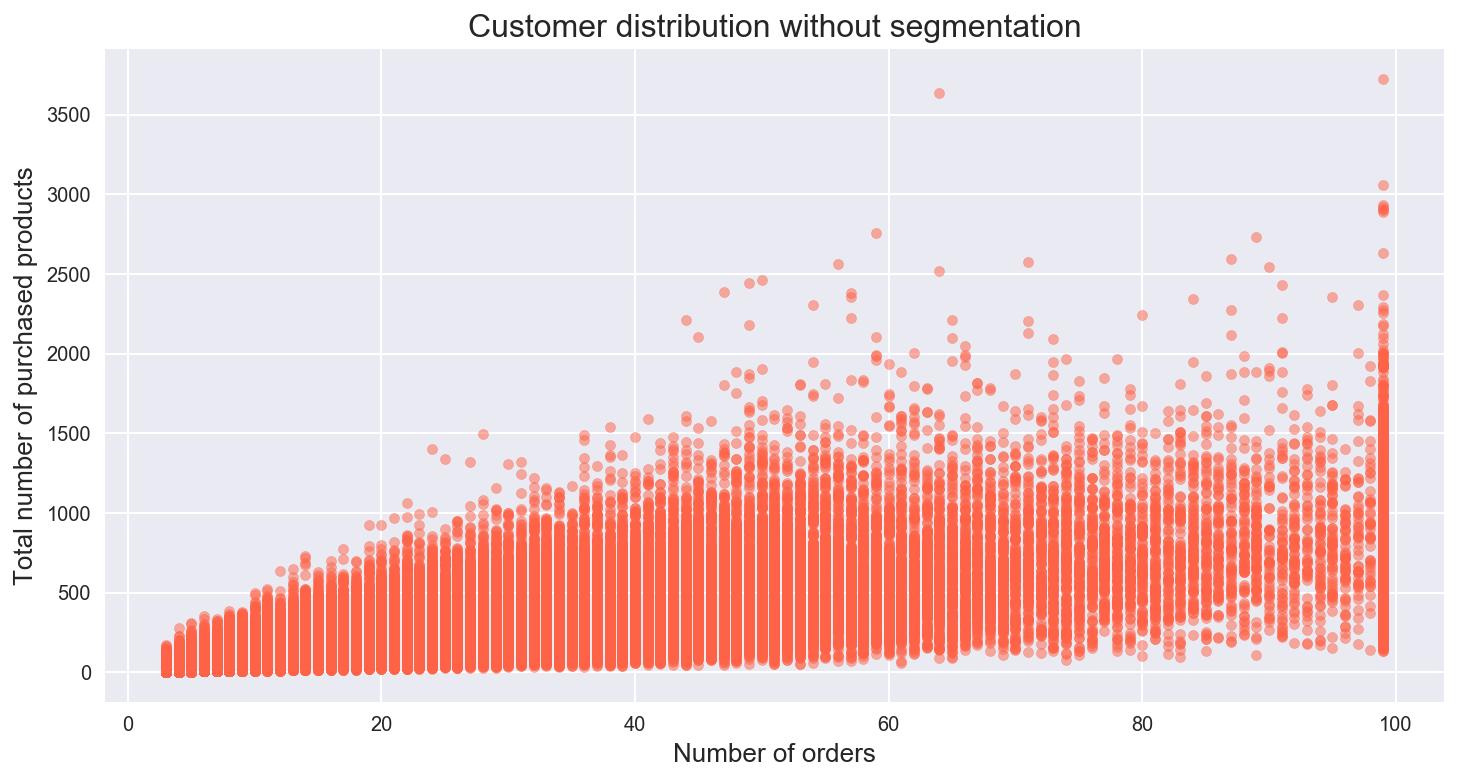

In [31]:
plt.figure(figsize=(12,6))
plt.scatter(
    user_info['total_orders'],
    user_info['total_purchased_items'],
    s=25,
    alpha=.5,
    color='tomato')
plt.title('Customer distribution without segmentation', fontdict={'fontsize':16})
plt.xlabel('Number of orders', fontdict={'fontsize':13})
plt.ylabel('Total number of purchased products', fontdict={'fontsize':13})
plt.show()

Distribution of the customer depending on the number of orders and the total number of products purchased is presented above. At this moment, the customers are not yet divided into smaller clusters, so all markers have the same color.

Next, customers will be divided into segments.

In [32]:
X = user_info[['total_orders', 'total_purchased_items']]
sc = StandardScaler()
X = sc.fit_transform(X)

The user_info table is limited only to the two most important columns ('total_orders', 'total_purchased_items') based on which segmentation will be carried out. In order to optimize the learning process itself, the data was standardized by removing the mean and scaling to unit variance.

In [33]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=123)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

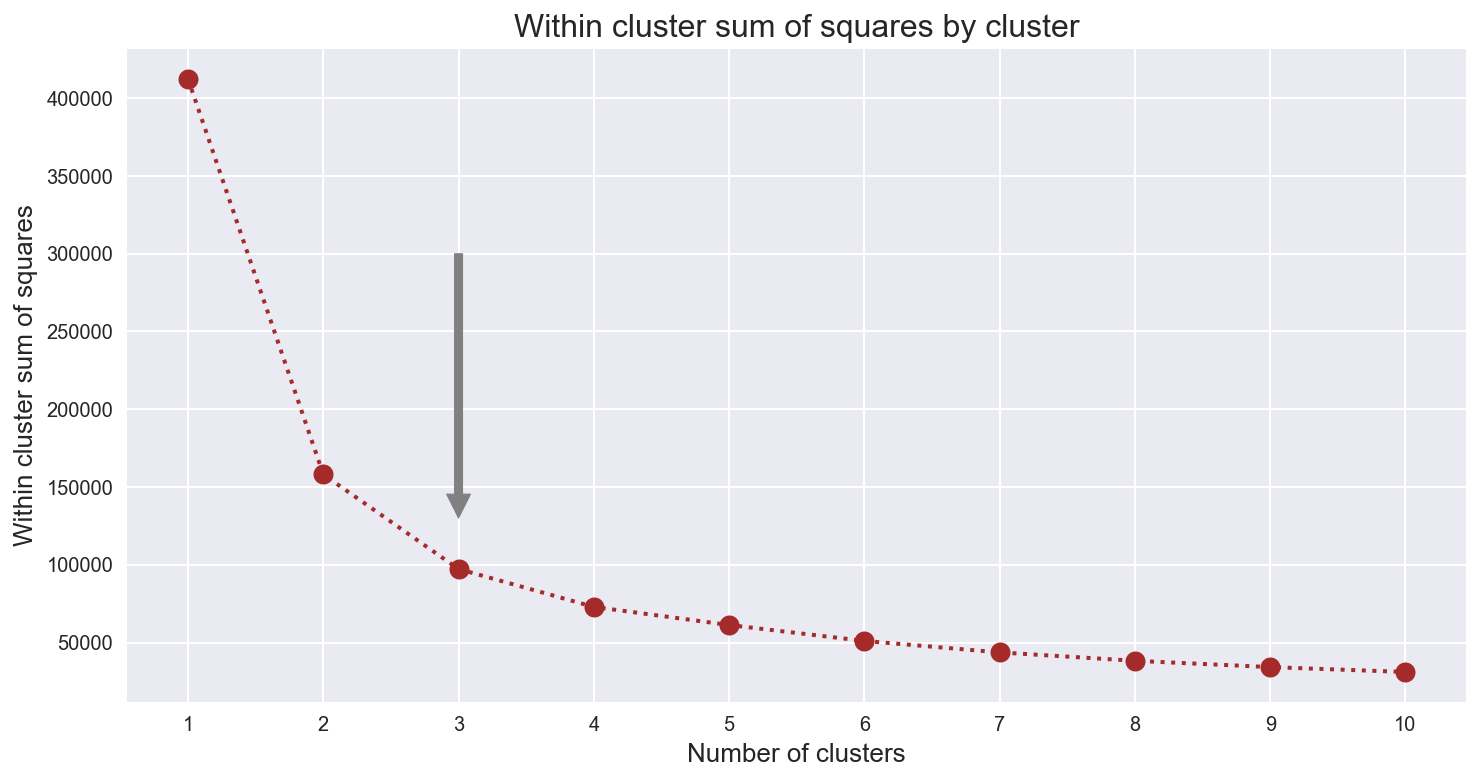

In [34]:
plt.figure(figsize=(12,6))
plt.plot(range(1,11), wcss, lw=2, marker='o', markersize=10, color='brown', ls=':')
plt.annotate(s='', xytext=(3, 300000), xy=(3, 130000),
             arrowprops={'lw': 0.5, 'color': 'gray'})
plt.title('Within cluster sum of squares by cluster', fontdict={'fontsize':16})
plt.xlabel('Number of clusters', fontdict={'fontsize':13})
plt.ylabel('Within cluster sum of squares', fontdict={'fontsize':13})
plt.xticks(np.arange(1,11))
plt.show()

To determine appropriate number of clusters in a data set sum of squares is calculated for each individual number. By translating the data into a graph above, an **elbow curve** is created. In clustering, this means one should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. In this case, the method indicates that the appropriate number of clusters would be **3** (marked with an arrow).

Although this value would be correct for standard machine learning, 3 may not be enough for customer segmentation. Such a small number of clusters would speak too little about individual clients in the group, so the number of **6** clusters is selected.

In [35]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=123)
kmeans.fit(X)

idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
temp = np.zeros(idx.shape)
temp[idx] = np.arange(6)
kmeans.labels_ = temp[kmeans.labels_]

user_info['cluster'] = kmeans.labels_
user_info['cluster'] = user_info['cluster'].astype('int8').astype('category')

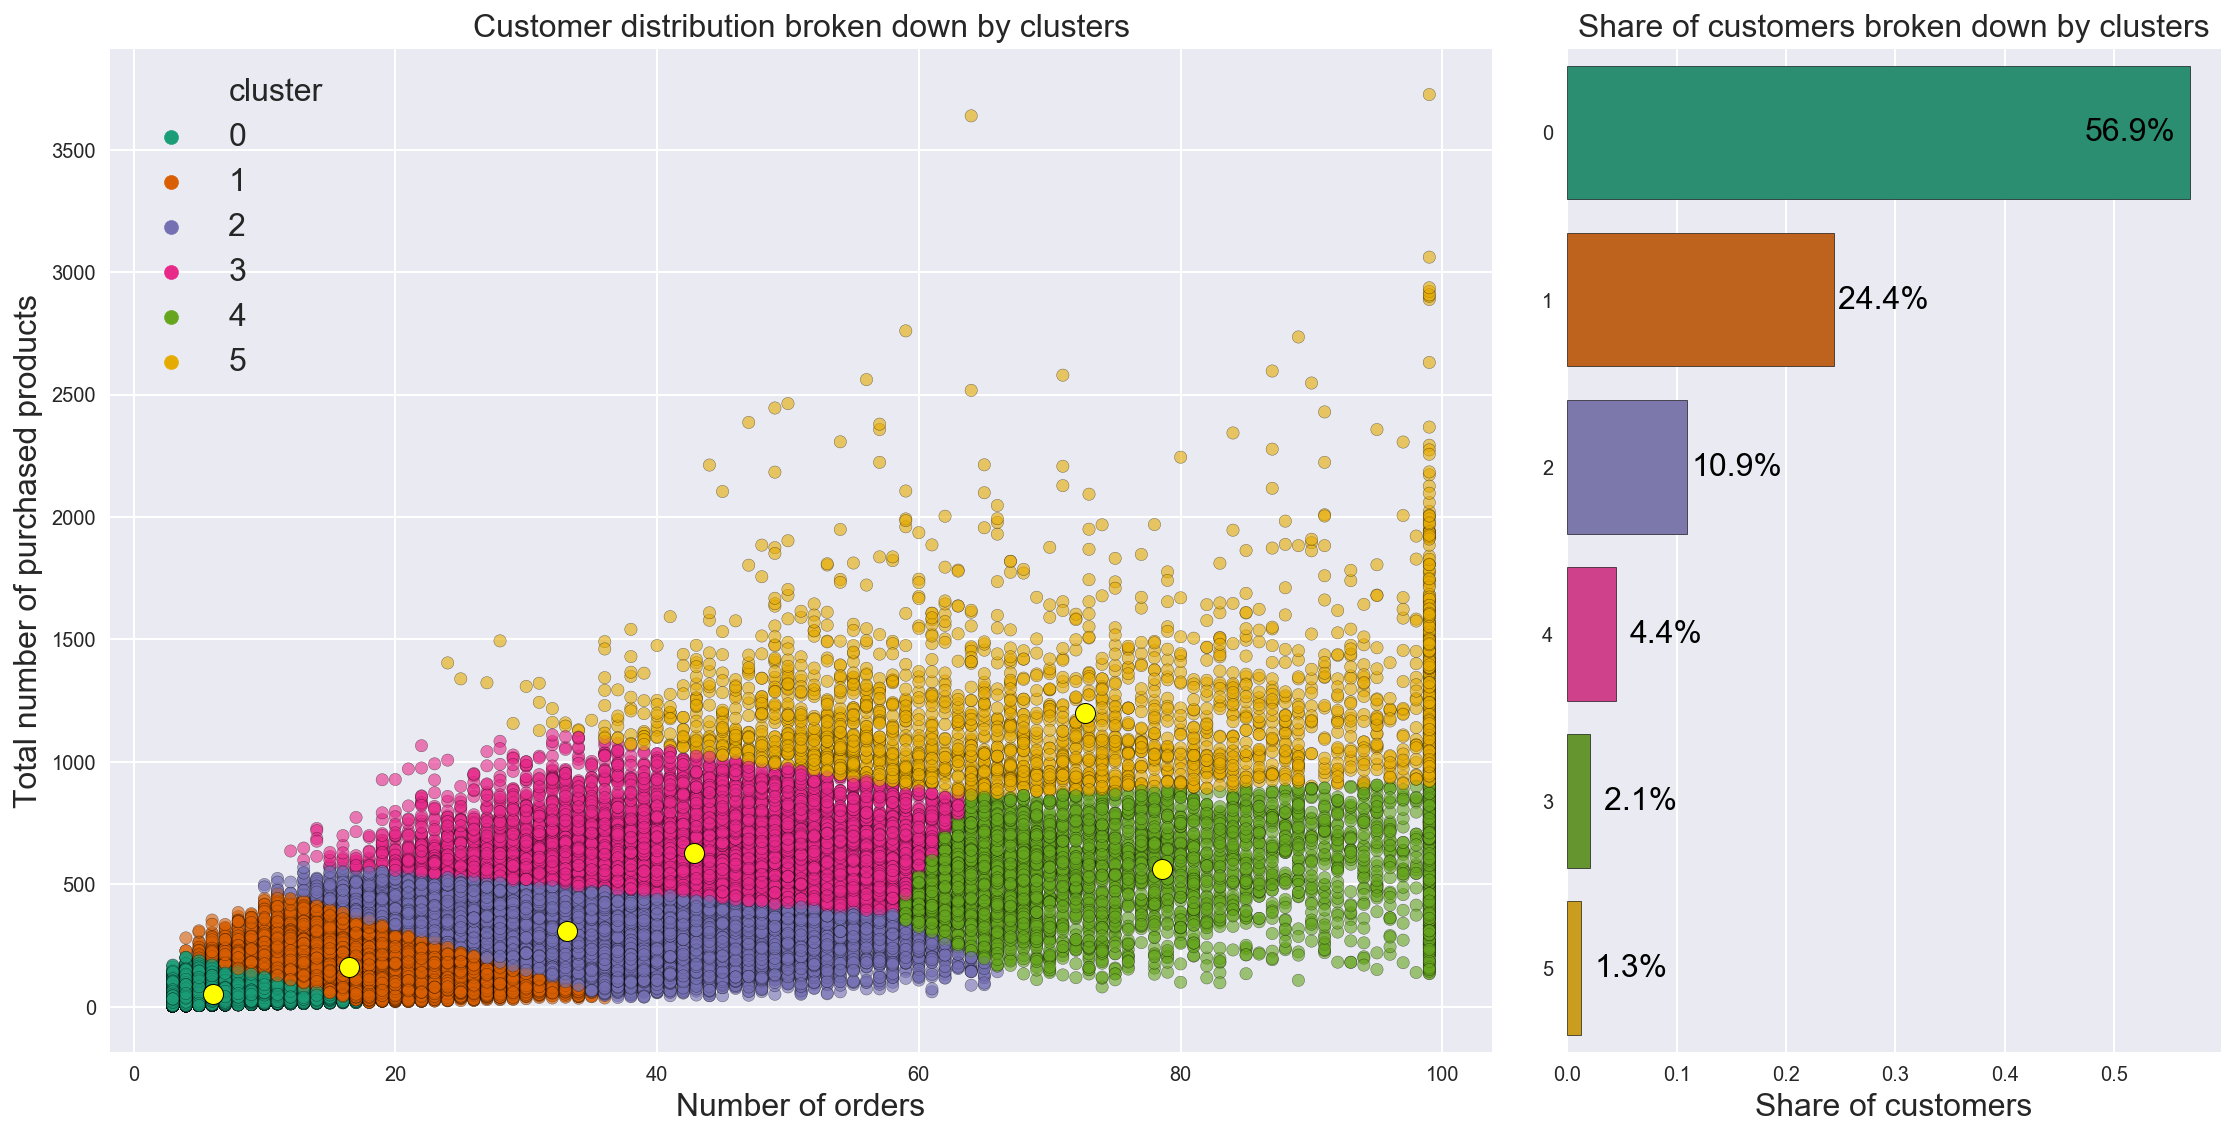

In [36]:
centers = sc.inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(16,8))
plt.subplot2grid((1, 3), (0, 0), colspan=2)
sns.scatterplot(
    data=user_info,
    x='total_orders',
    y='total_purchased_items',
    hue='cluster',
    palette='Dark2',
    edgecolor='black',
    linewidth=0.2,
    s=38,
    alpha=0.6)
plt.scatter(
    x=centers[:,0],
    y=centers[:,1],
    c='yellow',
    s=100,
    edgecolor='black',
    linewidth=0.5)

plt.title('Customer distribution broken down by clusters', fontdict={'fontsize':16})
plt.xlabel('Number of orders', fontdict={'fontsize':16})
plt.ylabel('Total number of purchased products', fontdict={'fontsize':16})
plt.legend(loc='upper left', prop={'size':16})

plt.subplot2grid((1, 3), (0, 2))
plot = sns.barplot(
    x=user_info['cluster'].value_counts()/user_info['cluster'].shape[0],
    y=user_info['cluster'].unique(),
    orient='h',
    palette='Dark2',
    edgecolor='black')
plot.annotate(
    s='{:.1%}'.format(plot.patches[0].get_width()),
    xy=(plot.patches[0].get_width(), plot.patches[0].get_y() + plot.patches[0].get_height()/2),
    ha='center', va='center', xytext=(-30, 0), textcoords='offset points', color='black', fontsize=16)
for p in plot.patches[1:]:
    plot.annotate(s='{:.1%}'.format(p.get_width()),xy=(p.get_width(), p.get_y() + p.get_height()/2),
    ha='center', va='center', xytext=(25, 0), textcoords='offset points', color='black',
    fontsize=16)

plt.title('Share of customers broken down by clusters',fontdict={'fontsize':16})
plt.xlabel('Share of customers', fontdict={'fontsize':16})
plt.ylabel('')

plt.tight_layout()
plt.show()

As presented above, 6 clusters seem to divide customers into logical segments. Clusters 0, 1 and 2 indicates customers who shop less frequently and buy less products, where the rest clusters (3, 4 and 5) symbolize customers using Instacart services much more often. What is worth emphasizing is the fact that although clusters 0 and 1 on scatterplot (on the left) seem to visually occupy the smallest area, the number of clients in these two clusters is over 80% of all customers. The number of loyal customers is actually much lower than the chart on the left would suggest.

However, what is the purpose of customer segmentation? Excluding the fact that it may allow a more detailed analysis of customers (more on this below), the company may consider introducing a loyalty program, where depending on the "level of commitment" of a given customer additional discounts may be offered. Considering that there are many more occasional clients than loyal ones, the introduction of this program may encourage them to make more frequent orders, thus increasing the company's profits.

In [37]:
cluster_info = user_info.groupby('cluster').mean()
cluster_info

total_orders  top_day  top_hour  mean_days_since_prior_order  \
cluster                                                                 
0             6.07462  2.75173  13.65921                     18.16938   
1            16.50112  2.73938  13.58192                     13.66489   
2            33.13188  2.77022  13.41095                      9.43053   
3            42.85597  2.72607  13.39518                      8.06143   
4            78.65168  2.88963  13.23589                      4.33065   
5            72.67789  2.83464  13.11747                      5.07034   

         total_purchased_items  mean_number_of_products  
cluster                                                  
0                     50.80253                  8.91806  
1                    162.10401                 10.94976  
2                    308.16097                 10.37509  
3                    628.98237                 15.71397  
4                    563.49426                  7.27083  
5                   1198.60382                 17.68361

Having clusters assigned to each customer, one can easily group data in such a way that it describes individual clusters.

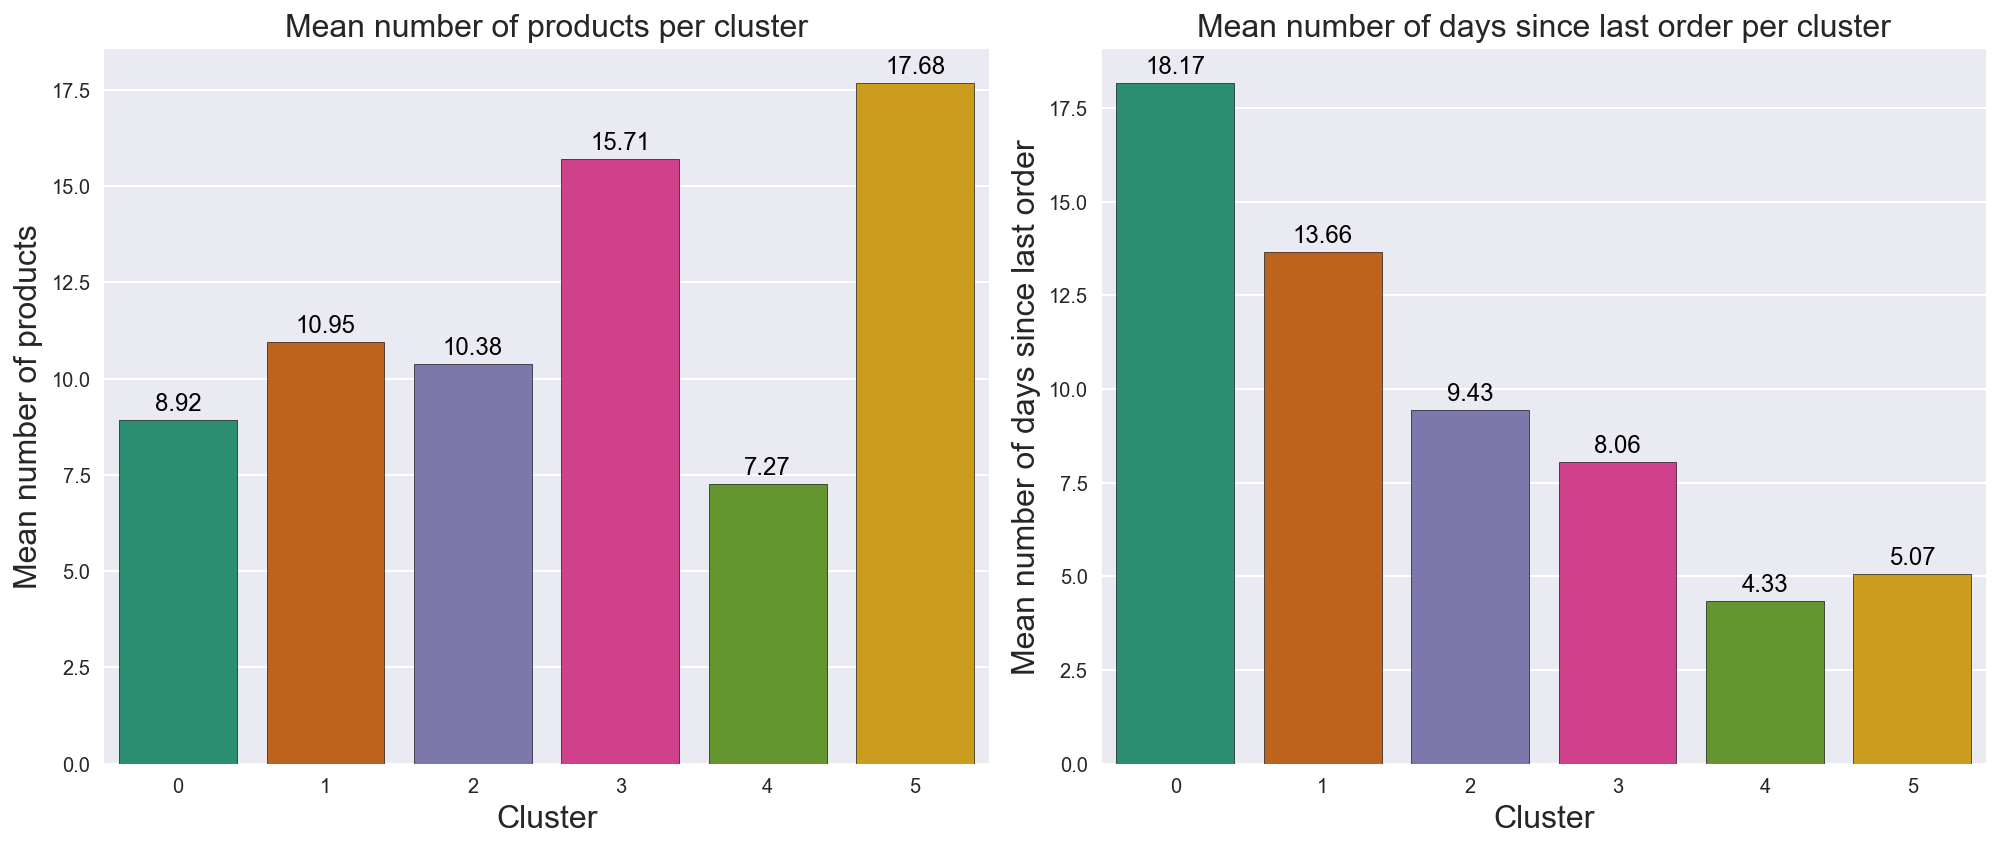

In [38]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plot = sns.barplot(
    x=cluster_info.index, 
    y=cluster_info['mean_number_of_products'], 
    palette='Dark2', 
    edgecolor='black')
display_count(plot, '{:.2f}', size=12)
plt.title('Mean number of products per cluster',fontdict={'fontsize':16})
plt.xlabel('Cluster', fontdict={'fontsize':16})
plt.ylabel('Mean number of products', fontdict={'fontsize':16})

plt.subplot(122)
plot = sns.barplot(
    x=cluster_info.index, 
    y=cluster_info['mean_days_since_prior_order'], 
    palette='Dark2', 
    edgecolor='black')
display_count(plot, '{:.2f}', size=12)

plt.title('Mean number of days since last order per cluster',fontdict={'fontsize':16})
plt.xlabel('Cluster', fontdict={'fontsize':16})
plt.ylabel('Mean number of days since last order', fontdict={'fontsize':16})

plt.tight_layout()
plt.show()

The above chart presents the data from the table created one step earlier in a more visually accessible form. The left chart shows a mean number of products per cluster. On its basis, it can be seen that by far the largest orders are made by clients described by the clusters 3 and 4. Whereas cluster 4, although it contains customers much more loyal than those who are in clusters 0, 1 and 2, the average number of products in the order is smaller even than these occasional customers.

The right chartas shows s mean number of days since last order per cluster. The downside tendency of the average number of days depending on the cluster is clearly visible. Excluding the last two clusters, the higher the number of cluster (and thus the cluster symbolize the more loyal customers), the shorter the time between orders.

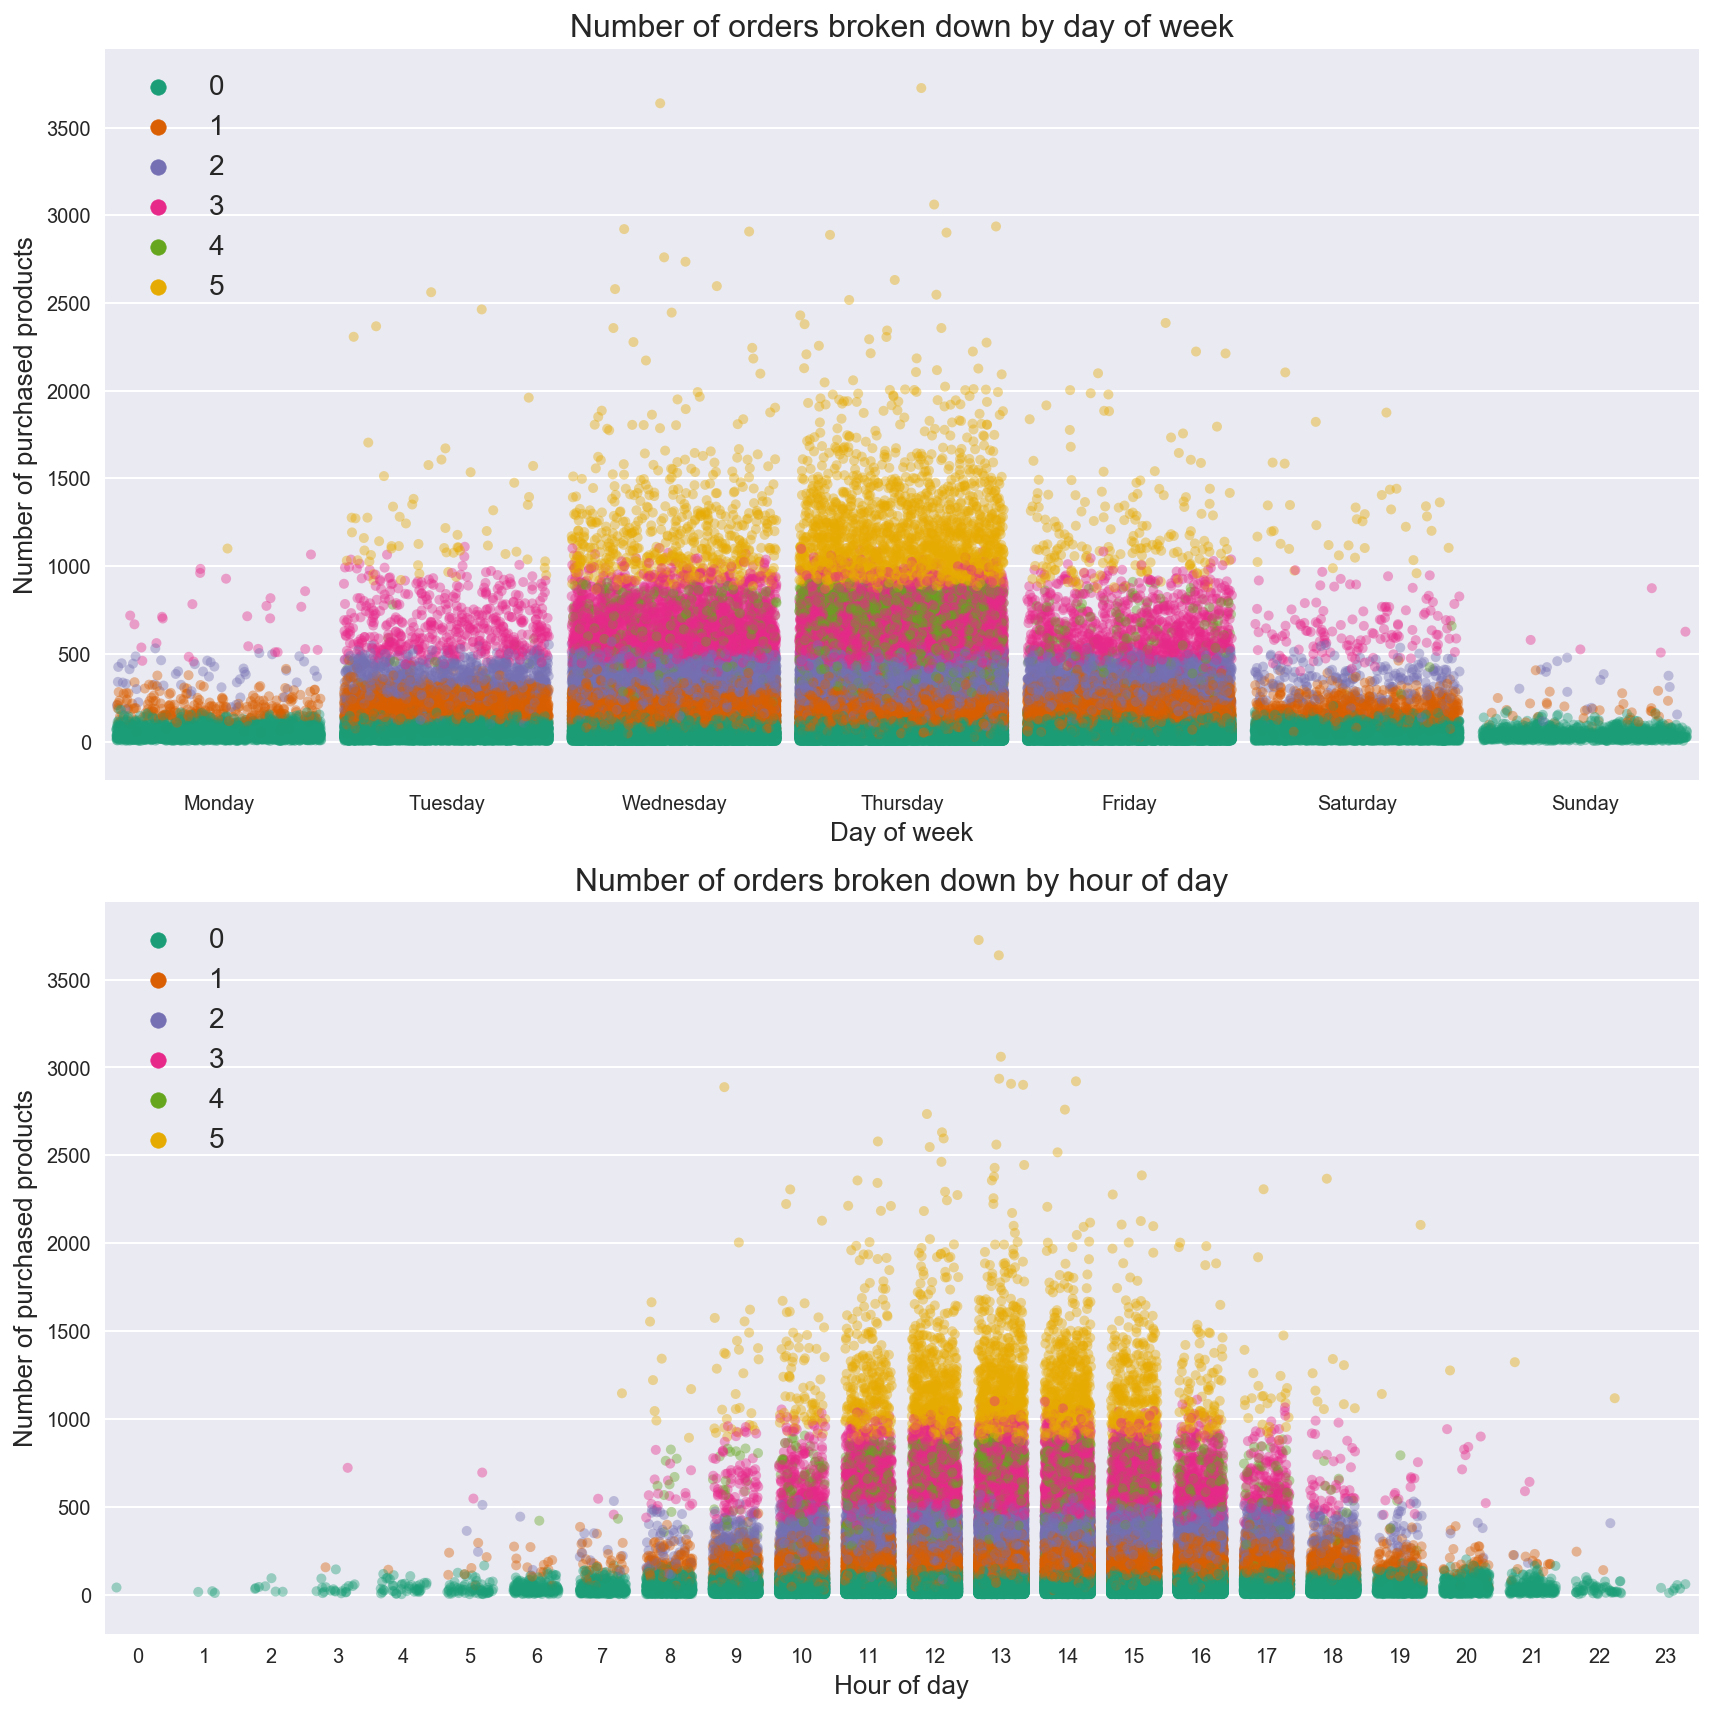

In [39]:
plt.figure(figsize=(12,12))

plt.subplot(211)
sns.stripplot(
    data=user_info, 
    x='top_day', 
    y='total_purchased_items',
    hue='cluster', 
    palette='Dark2',
    jitter=0.45,
    alpha=0.4)
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of orders broken down by day of week', fontdict={'fontsize':16})
plt.xlabel('Day of week', fontdict={'fontsize':13})
plt.ylabel('Number of purchased products', fontdict={'fontsize':13})
plt.legend(loc='upper left', prop={'size':14})

plt.subplot(212)
sns.stripplot(
    data=user_info, 
    x='top_hour', 
    y='total_purchased_items',
    hue='cluster', 
    palette='Dark2',
    jitter=0.35,
    alpha=0.4)
plt.title('Number of orders broken down by hour of day', fontdict={'fontsize':16})
plt.xlabel('Hour of day', fontdict={'fontsize':13})
plt.ylabel('Number of purchased products', fontdict={'fontsize':13})
plt.legend(loc='upper left', prop={'size':14})

plt.tight_layout()
plt.show()

Above is presented a graph similar to that at the beginning of the analysis, i.e.  based on the day of the week and the hour of placing the order. In this case, however, no bar chart was created, but a scatterplot where each dot symbolizes a single customer. It should be noted that the segmentation causes a visual gradual overlap of clusters, where clusters with lower numbers lie at the bottom of the charts, and clusters with higher numbers are located above, on top of them. This relationship applies to both charts, i.e. the day and hour of placing the order. 

An interesting fact arising from the above analysis is that customers from higher-order clusters shop almost exclusively from Tuesday to Friday and during the day, i.e. from 9 to 17. There is no such relationship among lower-order clusters, where orders are placed fairly evenly, every day of the week and within a wider range of hours. The reason for the above can be, for example, a promotion that encourages more loyal customers to order in the middle of the week.

## Association Rule Mining

Association rule mining is a technique to identify underlying relations between different items. More profit can be generated if the relationship between the items purchased in different transactions can be identified. By identifying pairs of products that are often bought together, a company can display and suggest the purchase of a second product when it sees that the first from the pair has been added to the basket. Product pairs will be searched for using the **apriori algorithm**.

In [40]:
transactions = []
prod_list = orders_prod.groupby(level=0)['product_name'].apply(list)

for item in prod_list:
    transactions.append(item)

The use of the apriori algorithm requires transformation of the data in such a way that all products in a given order are in the form of a simple list of list. Below sample products for first order is presented.

In [41]:
transactions[0]

['Organic Egg Whites',
 'Coconut Butter',
 'Natural Sweetener',
 'Carrots',
 'Garlic Powder',
 'Classic Blend Cole Slaw',
 'All Natural No Stir Creamy Almond Butter',
 'Original Unflavored Gelatine Mix',
 'Michigan Organic Kale']

In [42]:
rules = apriori(
    transactions, 
    min_support=.002, 
    min_confidence=.2, 
    min_lift=3, 
    min_lenght=2) 
results = list(rules)

There are three major components of Apriori algorithm (source:https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/):
- **Support** - refers to the default popularity of an item and can be calculated by finding number of transactions containing a particular item divided by total number of transactions
- **Confidence** - refers to the likelihood that an item B is also bought if item A is bought. 
- **Lift** - refers to the increase in the ratio of sale of B when A is sold

In the above case, the search for pairs will take place using the parameters specified above.

In [43]:
print('Total number of associations: {}\n'.format(len(results)))

for i in range(10):
    print('{}: {}'.format(i+1, list(results[i][0])))

Total number of associations: 40

1: ['Bunched Cilantro', 'Limes']
2: ['Organic Baby Spinach', 'Feta Cheese Crumbles']
3: ['Frozen Organic Wild Blueberries', 'Organic Whole Strawberries']
4: ['Icelandic Style Skyr Blueberry Non-fat Yogurt', 'Non Fat Raspberry Yogurt']
5: ['Icelandic Style Skyr Blueberry Non-fat Yogurt', 'Vanilla Skyr Nonfat Yogurt']
6: ['Jalapeno Peppers', 'Limes']
7: ['Sparkling Lemon Water', 'Lime Sparkling Water']
8: ['Lime Sparkling Water', 'Sparkling Water Grapefruit']
9: ['Organic Cilantro', 'Limes']
10: ['Orange Bell Pepper', 'Yellow Bell Pepper']


The use of the above parameters leads to the discovery of 40 associations - 10 of them are presented above. For example, buying a 'Bunched Cilantro' by a customer suggests that this customet may also be interested in buying 'Limes'. Similarly, 'Icelandic Style Skyr Non-fat Yogurt' is often bought together in a variety of flavors.

However, 40 connections are not a big result for almost 50,000 products. Such information would not significantly change the company's financial result - parameters should be changed in such a way that more connections are discovered. In this case, however, something else will be done. The search will be carried out again, but only on the basis of individual departments. This should help find more links between products in the same category.

In [44]:
def apriori_derivate(support):
    rules = apriori(
      transactions, 
      min_support=support, 
      min_confidence=.2, 
      min_lift=3, 
      min_lenght=2) 
    return rules

Due to the fact that the  departments-based search will be performed in loop, the second-level function is defined, in which the apriori function is included without the support parameter defined.

In [45]:
final_results = []
for department in departments.values:
    prod_list_dep = orders_prod[orders_prod['department'] == department[0]
                               ].groupby(level=0)['product_name'].apply(list)
    transactions = []
    for item in prod_list_dep:
        transactions.append(item)
    rules = apriori_derivate(support=0.002)
    results = list(rules)
    if len(list(results)) < 5:
        rules = apriori_derivate(support=0.001)
        results = list(rules)
        if len(list(results)) < 5:
            rules = apriori_derivate(support=0.0008)
            results = list(rules)
            if len(list(results)) < 5:
                rules = apriori_derivate(support=0.0006)
                results = list(rules)
    final_results.append([department, list(results)])

The steps taken to determine the relationship between the products have been repeated above. Due to the fact that each department has different sales and the number of products, it would be a good idea to use the grid search function to find the right parameters for each department. Due to computer calculation limitations, the search method will be slightly simplified - if no associative rules have been found or less than 5 associative rules has been found, the search will be repeated with the reduced support parameter, i.e. the parameter responsible for the popularity of a product.

In [46]:
apriori_score = pd.DataFrame()
for row in final_results:
    apriori_score.loc[row[0][0], 'association_rules'] = int(len(row[1]))

apriori_score['association_rules'] = apriori_score['association_rules'].astype('int16')
apriori_score = pd.merge(
    apriori_score, 
    products.groupby('department').count()['product_name'], 
    left_index=True, 
    right_index=True)
apriori_score.rename({'product_name': 'products'}, axis=1, inplace=True)

print('Total number of associations: {}\n'.format(apriori_score.sum()[0]))
apriori_score.sort_values('association_rules', ascending=False)

Total number of associations: 334



association_rules  products
babies                         172      1081
pets                            45       972
produce                         28      1684
missing                         21      1258
alcohol                         14      1054
beverages                       12      4365
dairy eggs                      11      3449
snacks                           5      6264
frozen                           5      4007
international                    5      1139
household                        4      3085
breakfast                        3      1115
canned goods                     3      2092
deli                             2      1322
personal care                    2      6563
other                            1       548
pantry                           1      5371
bulk                             0        38
meat seafood                     0       907
dry goods pasta                  0      1858
bakery                           0      1516

The above method creates more possible connections, in this case as many as 334. It is still quite small for such a large number of products, further change of parameters would be suggested.
At the moment, the most links are in the 'babies' category.

## Bonus - alternative customer segmentation by purchased products

Lastly, customer segmentation according to a different criterion than the number of orders and purchased products will be shown. Previously, such criteria were chosen, because thanks to this it was easy to visualize. This time, customers will be grouped according to purchased product categories (based on aisles).

In [47]:
to_cluster = pd.merge(users, orders_prod['aisle'], left_on='order_id', right_index=True)
to_cluster = pd.crosstab(to_cluster.index, to_cluster['aisle'])

to_cluster.head()

aisle  air fresheners candles  asian foods  baby accessories  \
row_0                                                          
1                           0            0                 0   
2                           0            3                 0   
3                           0            0                 0   
4                           0            0                 0   
5                           0            2                 0   

aisle  baby bath body care  baby food formula  bakery desserts  \
row_0                                                            
1                        0                  0                0   
2                        0                  0                0   
3                        0                  0                0   
4                        0                  0                0   
5                        0                  0                0   

aisle  baking ingredients  baking supplies decor  beauty  beers coolers  ...  \
row_0                                                                    ...   
1                       0                      0       0              0  ...   
2                       2                      0       0              0  ...   
3                       0                      0       0              0  ...   
4                       0                      0       0              0  ...   
5                       0                      0       0              0  ...   

aisle  spreads  tea  tofu meat alternatives  tortillas flat bread  \
row_0                                                               
1            1    0                       0                     0   
2            3    1                       1                     0   
3            4    1                       0                     0   
4            0    0                       0                     1   
5            0    0                       0                     0   

aisle  trail mix snack mix  trash bags liners  vitamins supplements  \
row_0                                                                 
1                        0                  0                     0   
2                        0                  0                     0   
3                        0                  0                     0   
4                        0                  0                     0   
5                        0                  0                     0   

aisle  water seltzer sparkling water  white wines  yogurt  
row_0                                                      
1                                  0            0       1  
2                                  2            0      42  
3                                  2            0       0  
4                                  1            0       0  
5                                  0            0       3  

[5 rows x 134 columns]

Appropriate transformation of the table may allow to assign to each customer the number of products he purchased from the given 'aisle'. Above the first 5 sample customers. Based on this data clustering will be processed.

In [48]:
to_cluster.shape

(206209, 134)

Unfortunately, the current table contains a lot of columns, and thus dimensions. The number of aisle is as much as 134, which translates into a 134-dimensional table. In addition, there are over 206,000 customers. All this leads to high computational requirements. To avoid this, dimensional reduction will be applied.

Principal Component Analysis (PCA) is a fast and flexible unsupervised method for dimensionality reduction in data. It is necessary to use unsupervised method because there is no output data in the data set - it is yet unknown how many and what will be the clusters.

In [49]:
#standarization of data
X = to_cluster
sc = StandardScaler()
X = sc.fit_transform(X)

#preparation of the PCA class for data
pca = PCA(n_components=None)
X = pca.fit_transform(X)

In [50]:
explained_variance = pca.explained_variance_ratio_.cumsum()
len(explained_variance)/2

67.0

To simplify the calculations, only half of the available columns will be used, i.e. 67. The columns that are responsible for the largest part of the variance will be selected.

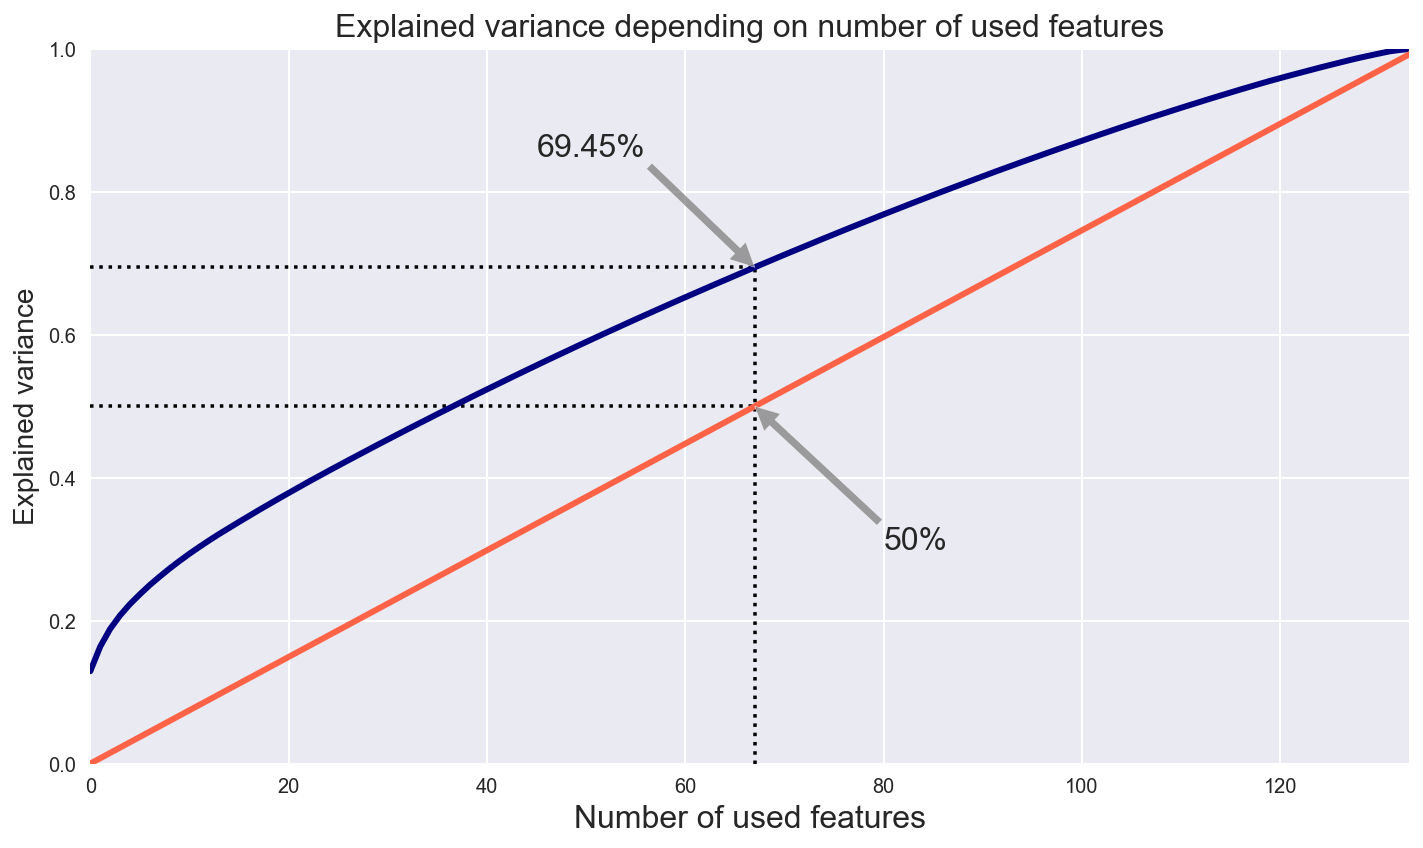

In [51]:
plt.figure(figsize=(10,6))

plt.plot(explained_variance, lw=3, color='navy')
plt.vlines(len(explained_variance)/2, 0, explained_variance[int(len(explained_variance)/2)], ls=':')
plt.hlines(explained_variance[int(len(explained_variance)/2)], 0, len(explained_variance)/2, ls=':')
plt.hlines(0.5, 0, len(explained_variance)/2, ls=':')
plt.plot([0,len(explained_variance)], [0,1], lw=3, color='tomato')

plt.annotate(s='50%', 
             xy=(67, 0.5), 
             size=16, 
             xytext=(80,0.3), 
             arrowprops=dict(facecolor='gray', alpha=0.75))

plt.annotate(s='{:.2%}'.format(pca.explained_variance_ratio_.cumsum()[int(len(explained_variance)/2)]), 
             xy=(67, pca.explained_variance_ratio_.cumsum()[int(len(explained_variance)/2)]), 
             size=16,
             xytext=(45,0.85), 
             arrowprops=dict(facecolor='gray', alpha=0.75))

plt.xlim(0, len(explained_variance)-1)
plt.ylim(0, 1)
plt.title('Explained variance depending on number of used features',fontdict={'fontsize':16})
plt.xlabel('Number of used features', fontdict={'fontsize':16})
plt.ylabel('Explained variance',fontdict={'fontsize':14})
plt.tight_layout()
plt.show()

As can be see in the graph above, using a randomly selected half of the columns would lead to 50% explained variance. However, selecting 67 columns using PCA leads to almost 70% of explained variance - this is the value on the basis of which further analysis is possible.

In [52]:
pca = PCA(n_components=67)
X = pca.fit_transform(X)

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=123)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

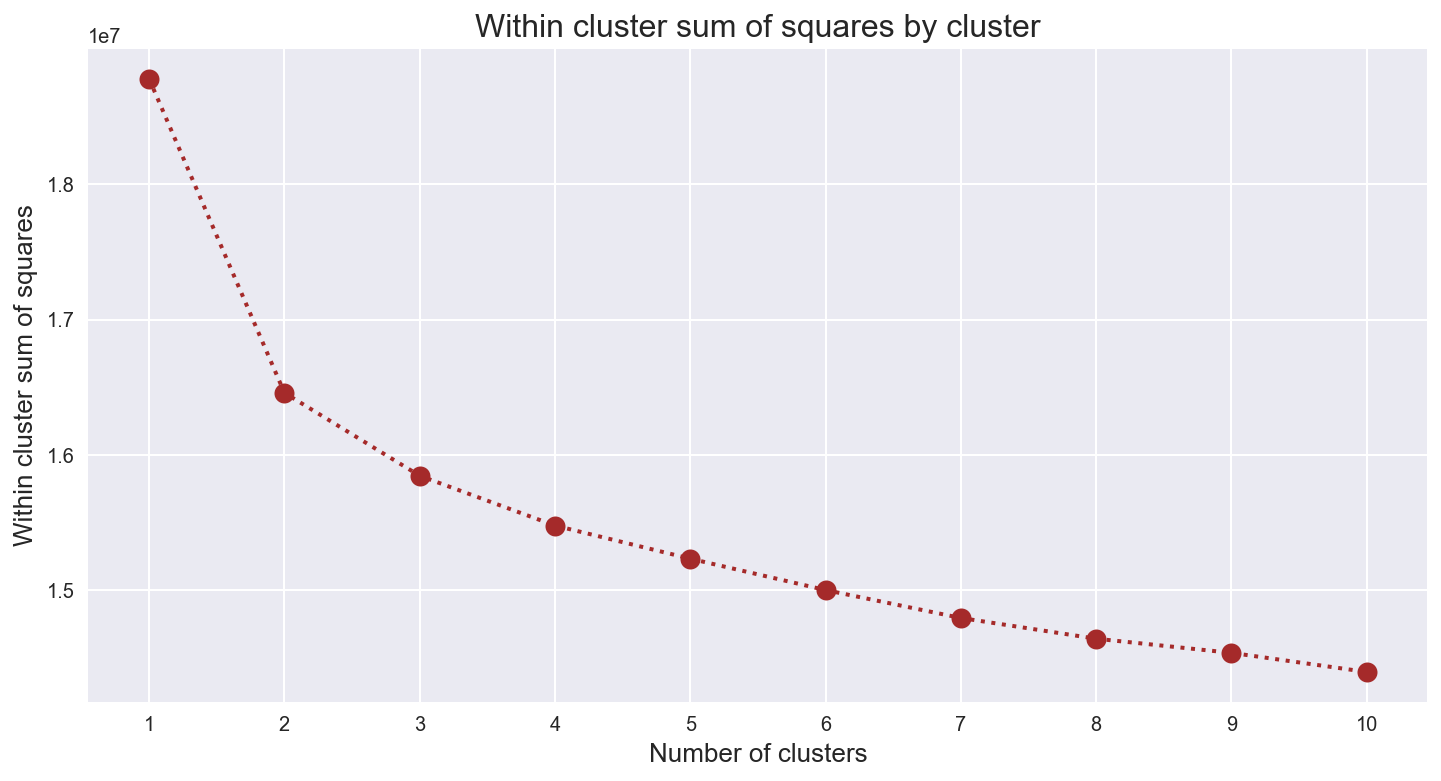

In [53]:
plt.figure(figsize=(12,6))
plt.plot(range(1,11), wcss, lw=2, marker='o', markersize=10, color='brown', ls=':')
plt.title('Within cluster sum of squares by cluster', fontdict={'fontsize':16})
plt.xlabel('Number of clusters', fontdict={'fontsize':13})
plt.ylabel('Within cluster sum of squares', fontdict={'fontsize':13})
plt.xticks(np.arange(1,11))
plt.show()

Again, when plotting  the elbow curve to determine the appropriate number of clusters, it seems that the appropriate number would be around 2, i.e. the biggest bend on the curve. As in the previous case, a larger number will be used to give the company greater opportunity to assign customers to segments.

In [54]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=123)
kmeans.fit(X)

to_cluster['cluster'] = kmeans.predict(X)
to_cluster.head()

aisle  air fresheners candles  asian foods  baby accessories  \
row_0                                                          
1                           0            0                 0   
2                           0            3                 0   
3                           0            0                 0   
4                           0            0                 0   
5                           0            2                 0   

aisle  baby bath body care  baby food formula  bakery desserts  \
row_0                                                            
1                        0                  0                0   
2                        0                  0                0   
3                        0                  0                0   
4                        0                  0                0   
5                        0                  0                0   

aisle  baking ingredients  baking supplies decor  beauty  beers coolers  ...  \
row_0                                                                    ...   
1                       0                      0       0              0  ...   
2                       2                      0       0              0  ...   
3                       0                      0       0              0  ...   
4                       0                      0       0              0  ...   
5                       0                      0       0              0  ...   

aisle  tea  tofu meat alternatives  tortillas flat bread  trail mix snack mix  \
row_0                                                                           
1        0                       0                     0                    0   
2        1                       1                     0                    0   
3        1                       0                     0                    0   
4        0                       0                     1                    0   
5        0                       0                     0                    0   

aisle  trash bags liners  vitamins supplements  water seltzer sparkling water  \
row_0                                                                           
1                      0                     0                              0   
2                      0                     0                              2   
3                      0                     0                              2   
4                      0                     0                              1   
5                      0                     0                              0   

aisle  white wines  yogurt  cluster  
row_0                                
1                0       1        2  
2                0      42        3  
3                0       0        2  
4                0       0        2  
5                0       3        2  

[5 rows x 135 columns]

# Thank you very much! :)